<a href="https://colab.research.google.com/github/esbahsohail6/sataaf/blob/with-trusted-and-random-assignment/trustscorelstmmaria_taskcompletion_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
employees = pd.read_csv('/content/employee_dataset_updated-completion.csv')
tasks = pd.read_csv('/content/df2_aligned.csv')

In [ ]:
employees.head()

,EmployeeID,Role,Skills,Competence Score,Security Score,Task Completion,Meeting Deadline,Trust Score,Profile Text,Availability Status
0,1,back-end developer,"JAVASCRIPT, EXPRESSJS, SQL",68.727006,97.535715,86.099,83.772,83.13,"Back-End Developer skilled in JAVASCRIPT, EXPR...",1
1,2,front-end developer,"CSS, HTML, JAVASCRIPT",86.599697,79.932924,84.247,83.751,83.27,"Front-End Developer skilled in CSS, HTML, JAVA...",1
2,3,back-end developer,"SQL, MONGODB, JAVASCRIPT",57.800932,57.799726,51.112,58.748,57.80,"Back-End Developer skilled in SQL, MONGODB, JA...",1
3,4,back-end developer,"JAVASCRIPT, NODEJS, SQL",52.904181,93.308807,78.713,73.000,73.11,"Back-End Developer skilled in JAVASCRIPT, NODE...",1
4,5,back-end developer,"SQL, NODEJS, EXPRESSJS",80.055751,85.403629,86.751,86.900,82.73,"Back-End Developer skilled in SQL, NODEJS, EXP...",1


In [ ]:
tasks.head()

,TaskID,Task Title,Difficulty,Handler Role,t1,t2,t3,AssignedEmployeeID
0,1,"Replace the content of the file ""mynewfileAdva...",Intermediate,back-end developer,JAVASCRIPT,NODEJS,EXPRESSJS,120
1,2,Test all the server,Intermediate,tester,MANUAL TESTING,NaN,NaN,117
2,3,Create HTML forms,Intermediate,front-end developer,HTML,CSS,BOOTSTRAP,184
3,4,Test all the handling,Advanced,tester,MANUAL TESTING,NaN,NaN,49
4,5,Create a function that will select random name...,Advanced,front-end developer,HTML,CSS,JAVASCRIPT,111


In [ ]:
employees["Competence Score"].min()


50.25307919

In [ ]:
employees["Competence Score"].max()

99.5252571

In [ ]:
#beginner 50-65
#intermediate 66-80
#advanced 80-100

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate


In [ ]:

y = employees["Trust Score"].values


In [ ]:
# One-hot encode Role
role_encoder = OneHotEncoder(sparse_output=False)
role_encoded = role_encoder.fit_transform(employees[["Role"]])

# Scale numerical features (Competence Score and Security Score)
scaler = MinMaxScaler()
numerical_features = scaler.fit_transform(employees[["Competence Score", "Security Score"]])

# Combine categorical and numerical features
X_text = np.concatenate([role_encoded, numerical_features], axis=1)


In [ ]:
# Tokenize text (limit vocab to top 5000 words)
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(employees["Skills"])

# Convert texts to sequences of integers
sequences = tokenizer.texts_to_sequences(employees["Skills"])

# Pad sequences so all have same length (choose maxlen=100 or suitable)
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')


In [ ]:
from sklearn.model_selection import train_test_split

# y is your target trust score array

X1 = X_text         # categorical + numeric features
X2 = padded_sequences  # text sequences

# Split both inputs and y together
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(
    X1, X2, y, test_size=0.2, random_state=42
)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate


In [ ]:
# Text input: padded skill sequences
text_input = Input(shape=(X2_train.shape[1],), name="skill_input")
x = Embedding(input_dim=5000, output_dim=64, input_length=X2_train.shape[1])(text_input)
x = LSTM(64)(x)

# Other features input: role (one-hot), competence score, security score
other_input = Input(shape=(X1_train.shape[1],), name="meta_input")
y = Dense(32, activation='relu')(other_input)

# Combine both branches
combined = Concatenate()([x, y])
z = Dense(64, activation='relu')(combined)
z = Dense(32, activation='relu')(z)
output = Dense(1)(z)  # Trust Score output

# Build the model
model = Model(inputs=[text_input, other_input], outputs=output)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ skill_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 64)   │    320,000 │ skill_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     33,024 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        224 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 361,569 (1.38 MB)

 Trainable params: 361,569 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    [X2_train, X1_train],  # Order must match model input order
    y_train,
    validation_data=([X2_test, X1_test], y_test),
    epochs=100,
    batch_size=32
)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - loss: 5765.7324 - mae: 75.1534 - val_loss: 5726.0303 - val_mae: 74.9341
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 5552.0894 - mae: 73.7113 - val_loss: 5483.4780 - val_mae: 73.2983
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 5217.7095 - mae: 71.5262 - val_loss: 5049.9385 - val_mae: 70.2813
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 4954.1680 - mae: 69.5773 - val_loss: 4561.6133 - val_mae: 66.7197
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4357.0283 - mae: 65.1589 - val_loss: 3945.3809 - val_mae: 61.9343
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 3606.0850 - mae: 59.0941 - val_loss: 3202.8757 - val_mae: 55.6246
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3015.6069 - mae: 53.9017 - val_loss: 2388.4214 - val_mae: 47.7576
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2102.3838 - mae: 44.7049 - val_loss: 1598.4329 - val_mae: 38.6303
Epoc

In [ ]:

loss, mae = model.evaluate([X2_test, X1_test], y_test)
print(f"Test MSE: {loss:.2f}")
print(f"Test MAE: {mae:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3082 - mae: 0.4448
Test MSE: 0.33
Test MAE: 0.46


In [ ]:
from sklearn.metrics import r2_score

y_pred = model.predict([X2_test, X1_test])
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.3f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
R² Score: 0.997


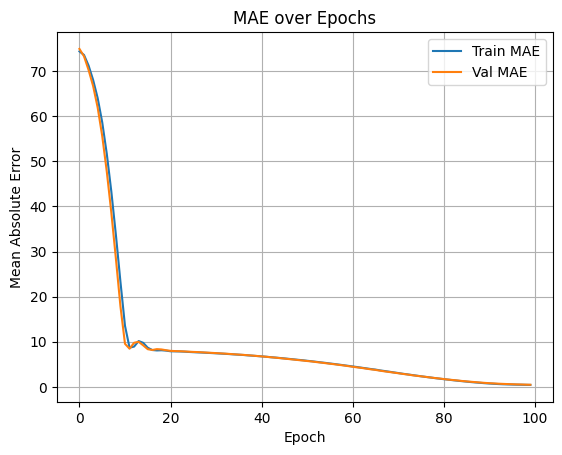

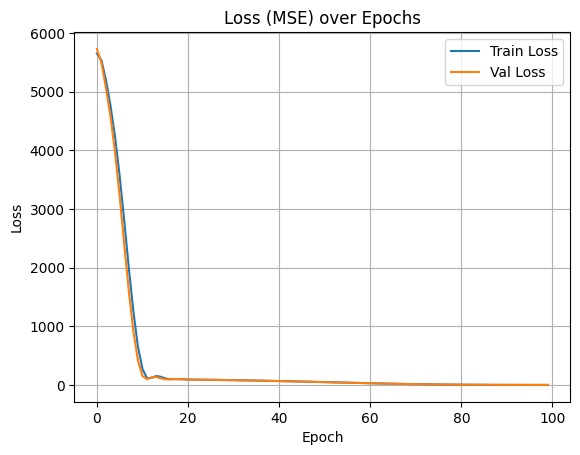

In [ ]:
import matplotlib.pyplot as plt

# Plot MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss (MSE) over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



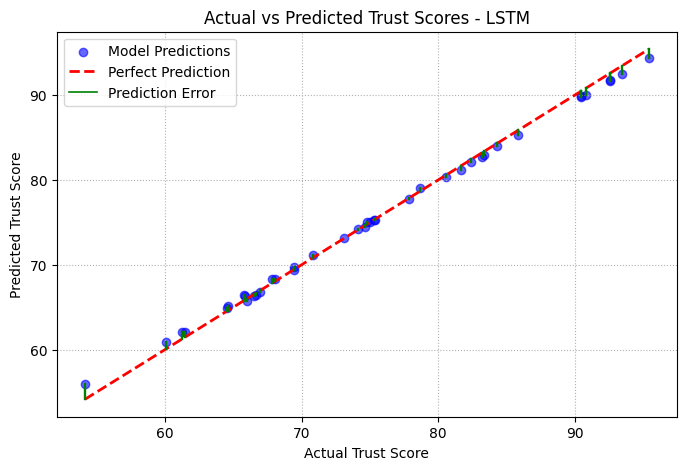

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Convert to NumPy arrays
y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred).flatten()

plt.figure(figsize=(8, 5))

# Scatter plot (blue for all predictions)
scatter = plt.scatter(y_test_arr, y_pred_arr, alpha=0.6, color="blue", label="Model Predictions")

# Reference line (perfect prediction)
ref_line, = plt.plot([min(y_test_arr), max(y_test_arr)],
                     [min(y_test_arr), max(y_test_arr)],
                     color="red", linestyle="--", linewidth=2, label="Perfect Prediction")

# Draw green lines for ALL points (showing displacement from reference line)
for x, y in zip(y_test_arr, y_pred_arr):
    plt.plot([x, x], [x, y], color="green", linewidth=1.7)

# Proxy line for legend (green displacement lines)
disp_line = mlines.Line2D([], [], color="green", linewidth=1.2, label="Prediction Error")

# Labels and title
plt.xlabel("Actual Trust Score")
plt.ylabel("Predicted Trust Score")
plt.title("Actual vs Predicted Trust Scores - LSTM")

# Grid + legend (combine all)
plt.grid(True, linestyle=":")
plt.legend(handles=[scatter, ref_line, disp_line], loc="best")

plt.show()


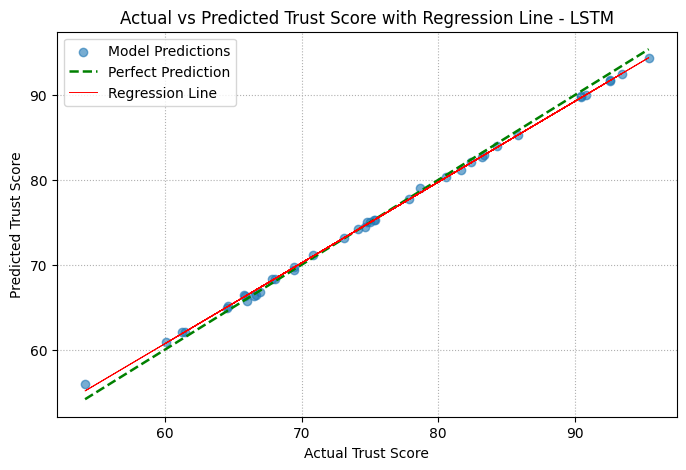

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Convert to NumPy arrays
y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred).flatten()

# Fit regression line
reg = LinearRegression().fit(y_test_arr.reshape(-1,1), y_pred_arr)
y_fit = reg.predict(y_test_arr.reshape(-1,1))

plt.figure(figsize=(8,5))
plt.scatter(y_test_arr, y_pred_arr, alpha=0.6, label="Model Predictions")
plt.plot([min(y_test_arr), max(y_test_arr)],
         [min(y_test_arr), max(y_test_arr)],
         color="green", linestyle="--",linewidth=1.8, label="Perfect Prediction")
plt.plot(y_test_arr, y_fit, color="red", linewidth=0.7, label="Regression Line")
plt.xlabel("Actual Trust Score")
plt.ylabel("Predicted Trust Score")
plt.title("Actual vs Predicted Trust Score with Regression Line - LSTM")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()


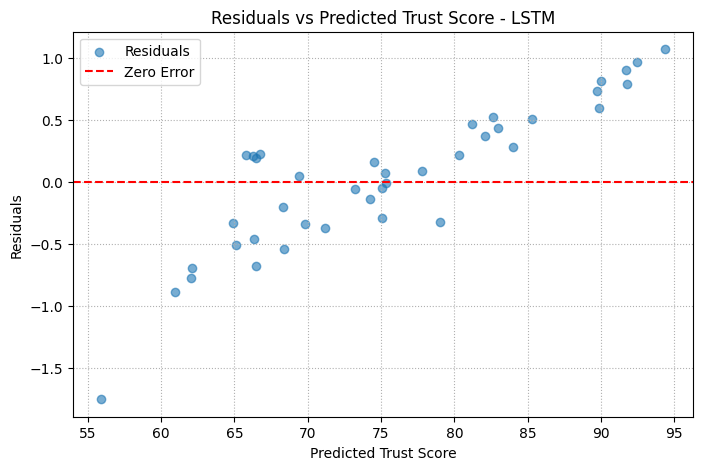

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# y_test_arr = np.array(y_test).flatten()
# y_pred_arr = np.array(y_pred).flatten()
# residuals = y_test_arr - y_pred_arr

# plt.figure(figsize=(8,5))
# plt.scatter(y_pred_arr, residuals, alpha=0.6)
# plt.axhline(0, color="red", linestyle="--")
# plt.xlabel("Predicted Trust Score")
# plt.ylabel("Residuals")
# plt.title("Residuals vs Predicted")
# plt.grid(True, linestyle=":")
# plt.show()

import numpy as np
import matplotlib.pyplot as plt

y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred).flatten()
residuals = y_test_arr - y_pred_arr

plt.figure(figsize=(8,5))

# Scatter residuals
plt.scatter(y_pred_arr, residuals, alpha=0.6, label="Residuals")

# Reference horizontal line at 0
plt.axhline(0, color="red", linestyle="--", label="Zero Error")

plt.xlabel("Predicted Trust Score")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Trust Score - LSTM")
plt.grid(True, linestyle=":")

# Add legend
plt.legend()

plt.show()



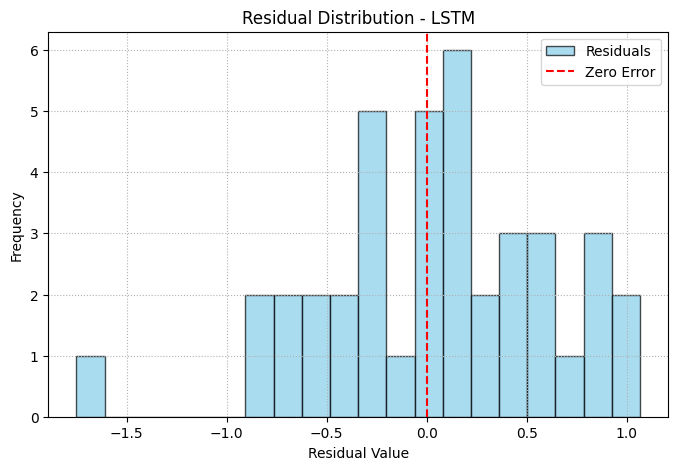

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# y_test_arr = np.array(y_test).flatten()
# y_pred_arr = np.array(y_pred).flatten()
# residuals = y_test_arr - y_pred_arr

# plt.figure(figsize=(8,5))
# plt.hist(residuals, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
# plt.axvline(0, color="red", linestyle="--")
# plt.xlabel("Residual Value")
# plt.ylabel("Frequency")
# plt.title("Residual Distribution")
# plt.grid(True, linestyle=":")
# plt.show()

import numpy as np
import matplotlib.pyplot as plt

y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred).flatten()
residuals = y_test_arr - y_pred_arr

plt.figure(figsize=(8,5))

# Histogram of residuals
plt.hist(residuals, bins=20, color="skyblue", edgecolor="black", alpha=0.7, label="Residuals")

# Reference line at 0
plt.axvline(0, color="red", linestyle="--", label="Zero Error")

plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Residual Distribution - LSTM")
plt.grid(True, linestyle=":")

# Add legend
plt.legend()

plt.show()



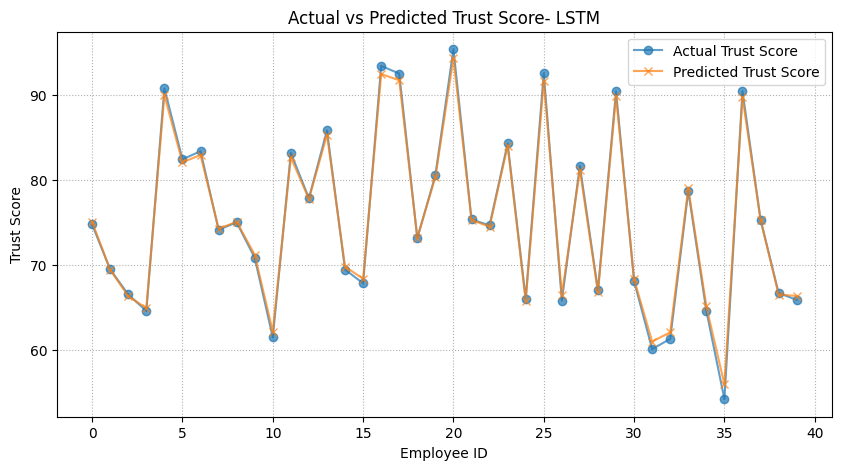

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred).flatten()

plt.figure(figsize=(10,5))
plt.plot(y_test_arr, label="Actual Trust Score", marker="o", alpha=0.7)
plt.plot(y_pred_arr, label="Predicted Trust Score", marker="x", alpha=0.7)
plt.xlabel("Employee ID")
plt.ylabel("Trust Score")
plt.title("Actual vs Predicted Trust Score- LSTM")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()


In [ ]:
# Save the model to an HDF5 file
model.save("trust_score_lstm.h5")

**CNN MODEL**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.optimizers import Adam

# Inputs
input_text = Input(shape=(100,), name='text_input')  # Tokenized skills
input_meta = Input(shape=(X_text.shape[1],), name='meta_input')  # One-hot role + scaled scores

# Embedding + CNN for text input
embedding_layer = Embedding(input_dim=5000, output_dim=64, input_length=100)(input_text)
conv_layer = Conv1D(128, 5, activation='relu')(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)

# Merge CNN output with meta features
combined = Concatenate()([pooling_layer, input_meta])
dense1 = Dense(64, activation='relu')(combined)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)  # Output: trust score

# Build and compile the model
cnn_model = Model(inputs=[input_text, input_meta], outputs=output)
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Summary
cnn_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 100, 64)   │    320,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 96, 128)   │     41,088 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 134)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      8,640 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 32)        │      2,080 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │         33 │ dense_15[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 371,841 (1.42 MB)

 Trainable params: 371,841 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history2 = cnn_model.fit([X2_train, X1_train], y_train, validation_data=([X2_test, X1_test], y_test), epochs=270, batch_size=16)

Epoch 1/270
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 5501.3706 - mae: 73.3851 - val_loss: 5564.3408 - val_mae: 73.8507
Epoch 2/270
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5272.8564 - mae: 71.7899 - val_loss: 3773.4644 - val_mae: 60.5258
Epoch 3/270
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2704.9404 - mae: 49.3959 - val_loss: 115.2008 - val_mae: 9.2501
Epoch 4/270
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 402.7214 - mae: 16.8277 - val_loss: 115.8246 - val_mae: 9.2863
Epoch 5/270
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 157.5407 - mae: 10.6745 - val_loss: 216.4450 - val_mae: 11.4611
Epoch 6/270
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 169.3173 - mae: 10.5407 - val_loss: 125.9836 - val_mae: 9.7345
Epoch 7/270
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 125.3609 - mae: 9.3487 - val_loss: 116.4278 - val_mae: 8.9134
Epoch 8/270
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 113.6629 - mae: 8.3769 - val_loss: 110.9957 - val_mae: 8.7263
Epoch 9/27

In [ ]:
loss, mae = cnn_model.evaluate([X2_test, X1_test], y_test)
print(f"Test MSE: {loss:.2f}")
print(f"Test MAE: {mae:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.6545 - mae: 2.1067
Test MSE: 7.33
Test MAE: 2.19


In [ ]:
from sklearn.metrics import r2_score

y_pred2 = cnn_model.predict([X2_test, X1_test])
r2 = r2_score(y_test, y_pred2)
print(f"R² Score: {r2:.3f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
R² Score: 0.934


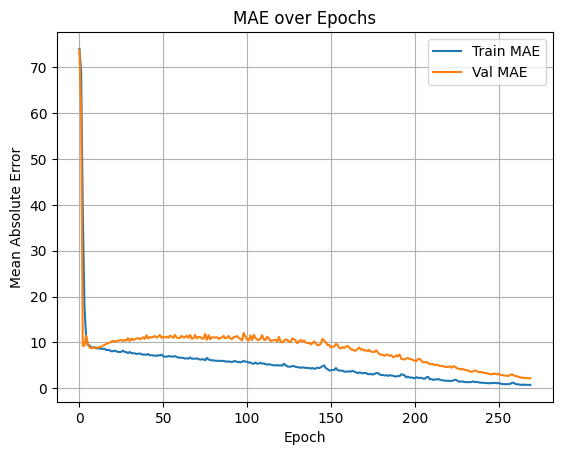

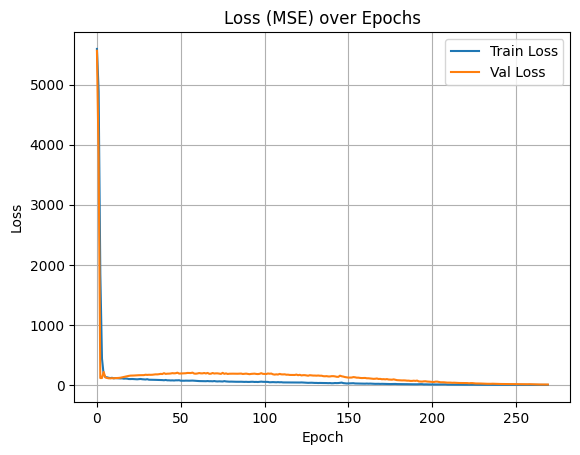

In [ ]:
import matplotlib.pyplot as plt

# Plot MAE
plt.plot(history2.history['mae'], label='Train MAE')
plt.plot(history2.history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('Loss (MSE) over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



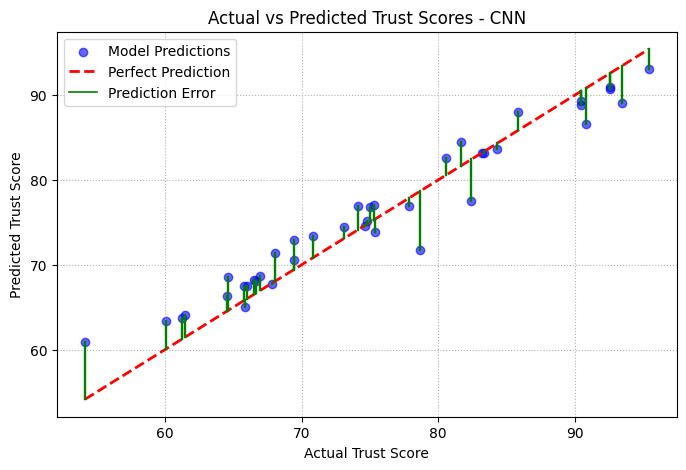

In [ ]:
# # plt.figure(figsize=(8, 5))
# # plt.scatter(y_test, y_pred2, alpha=0.6)
# # plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
# # plt.xlabel('Actual Trust Score')
# # plt.ylabel('Predicted Trust Score')
# # plt.title('Actual vs Predicted Trust Scores')
# # plt.grid(True)
# # plt.show()



# # import numpy as np
# # import matplotlib.pyplot as plt

# # plt.figure(figsize=(8, 5))

# # # Scatter plot
# # plt.scatter(y_test, y_pred2, alpha=0.6, label="Predicted vs Actual")

# # # Reference line (perfect prediction)
# # plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
# #          color='red', linestyle='--', label="Perfect Prediction")

# # # Residuals (distance from the line)
# # residuals = np.abs(y_test - y_pred2)

# # # Threshold for highlighting large displacements
# # threshold = np.std(residuals)
# # outliers = residuals > threshold

# # # Highlight large displacement points
# # plt.scatter(y_test[outliers], y_pred2[outliers],
# #             color='orange', edgecolors='black', s=80,
# #             label="Large Displacement")

# # # Labels and title
# # plt.xlabel('Actual Trust Score')
# # plt.ylabel('Predicted Trust Score')
# # plt.title('Actual vs Predicted Trust Scores')

# # # Grid + legend
# # plt.grid(True)
# # plt.legend()

# # plt.show()


# # import numpy as np
# # import matplotlib.pyplot as plt

# # # Convert to 1-D NumPy arrays
# # y_test_arr = np.array(y_test).flatten()
# # y_pred2_arr = np.array(y_pred2).flatten()

# # plt.figure(figsize=(8, 5))

# # # Scatter plot
# # plt.scatter(y_test_arr, y_pred2_arr, alpha=0.6, label='Model Predictions')

# # # Reference line (perfect prediction)
# # plt.plot([min(y_test_arr), max(y_test_arr)],
# #          [min(y_test_arr), max(y_test_arr)],
# #          color='red', linestyle='--', label="Perfect Prediction")

# # # Residuals (distance from the line)
# # residuals = np.abs(y_test_arr - y_pred2_arr)

# # # Threshold for highlighting large displacements
# # threshold = np.std(residuals)
# # outliers = residuals > threshold

# # # Highlight large displacement points
# # plt.scatter(y_test_arr[outliers], y_pred2_arr[outliers],
# #             color='orange', edgecolors='black', s=80,
# #             label="Large Displacement")

# # # Labels and title
# # plt.xlabel('Actual Trust Score')
# # plt.ylabel('Predicted Trust Score')
# # plt.title('Actual vs Predicted Trust Scores - CNN')

# # # Grid + legend
# # plt.grid(True)
# # plt.legend()

# # plt.show()


# # import numpy as np
# # import matplotlib.pyplot as plt

# # # Convert to 1-D NumPy arrays
# # y_test_arr = np.array(y_test).flatten()
# # y_pred2_arr = np.array(y_pred2).flatten()

# # plt.figure(figsize=(8, 5))

# # # Scatter plot
# # plt.scatter(y_test_arr, y_pred2_arr, alpha=0.6, label='Model Predictions')

# # # Reference line (perfect prediction)
# # plt.plot([min(y_test_arr), max(y_test_arr)],
# #          [min(y_test_arr), max(y_test_arr)],
# #          color='red', linestyle='--', label="Perfect Prediction")

# # # Residuals (distance from the line)
# # residuals = np.abs(y_test_arr - y_pred2_arr)

# # # Get indices of 3 farthest points
# # top3_idx = np.argsort(residuals)[:]

# # # Draw dotted lines from each farthest point to the reference line
# # for i in top3_idx:
# #     x = y_test_arr[i]   # Actual value
# #     y = y_pred2_arr[i]  # Predicted value
# #     plt.plot([x, x], [x, y], color='orange', linestyle='--', linewidth=1)
# #     plt.scatter(x, y, color='orange', edgecolors='black', s=80)

# # # Labels and title
# # plt.xlabel('Actual Trust Score')
# # plt.ylabel('Predicted Trust Score')
# # plt.title('Actual vs Predicted Trust Scores - CNN')

# # # Grid + legend
# # plt.grid(True)
# # plt.legend()

# # plt.show()

# # import numpy as np
# # import matplotlib.pyplot as plt

# # # Convert to 1-D NumPy arrays
# # y_test_arr = np.array(y_test).flatten()
# # y_pred2_arr = np.array(y_pred2).flatten()

# # plt.figure(figsize=(8, 5))

# # # Scatter plot (blue for all predictions)
# # plt.scatter(y_test_arr, y_pred2_arr, alpha=0.6, color='blue', label='Model Predictions')

# # # Reference line (perfect prediction)
# # plt.plot([min(y_test_arr), max(y_test_arr)],
# #          [min(y_test_arr), max(y_test_arr)],
# #          color='red', linestyle='--', linewidth=2, label="Perfect Prediction")

# # # Draw dotted lines for ALL points (showing displacement from reference line)
# # for x, y in zip(y_test_arr, y_pred2_arr):
# #     plt.plot([x, x], [x, y], color='green', linewidth=1.2)

# # # Labels and title
# # plt.xlabel('Actual Trust Score')
# # plt.ylabel('Predicted Trust Score')
# # plt.title('Actual vs Predicted Trust Scores - CNN')

# # # Grid + legend
# # plt.grid(True, linestyle=':')
# # plt.legend()

# # plt.show()

# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.lines as mlines

# # Convert to 1-D NumPy arrays
# y_test_arr = np.array(y_test).flatten()
# y_pred2_arr = np.array(y_pred2).flatten()

# plt.figure(figsize=(8, 5))

# # Scatter plot (blue for all predictions)
# plt.scatter(y_test_arr, y_pred2_arr, alpha=0.6, color='blue', label='Model Predictions')

# # Reference line (perfect prediction)
# plt.plot([min(y_test_arr), max(y_test_arr)],
#          [min(y_test_arr), max(y_test_arr)],
#          color='red', linestyle='--', linewidth=2, label="Perfect Prediction")

# # Draw green lines for ALL points (showing displacement from reference line)
# for x, y in zip(y_test_arr, y_pred2_arr):
#     plt.plot([x, x], [x, y], color='green', linewidth=1.2)

# # Add proxy artist for green displacement lines in legend
# displacement_line = mlines.Line2D([], [], color='green', linewidth=1.2, label='Prediction Error')

# # Labels and title
# plt.xlabel('Actual Trust Score')
# plt.ylabel('Predicted Trust Score')
# plt.title('Actual vs Predicted Trust Scores - CNN')

# # Grid + legend (with proxy line)
# plt.grid(True, linestyle=':')
# plt.legend(handles=[displacement_line], loc='best')
# plt.legend()

# plt.show()



# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.lines as mlines

# # Convert to 1-D NumPy arrays
# y_test_arr = np.array(y_test).flatten()
# y_pred2_arr = np.array(y_pred2).flatten()

# plt.figure(figsize=(8, 5))

# # Scatter plot (blue for all predictions)
# scatter = plt.scatter(y_test_arr, y_pred2_arr, alpha=0.6, color='blue', label='Model Predictions')

# # Reference line (perfect prediction)
# ref_line, = plt.plot([min(y_test_arr), max(y_test_arr)],
#                      [min(y_test_arr), max(y_test_arr)],
#                      color='red', linestyle='--', linewidth=2, label="Perfect Prediction")

# # Draw green lines for ALL points (showing displacement from reference line)
# for x, y in zip(y_test_arr, y_pred2_arr):
#     plt.plot([x, x], [x, y], color='green', linewidth=1.2)

# # Proxy line for green displacement
# disp_line = mlines.Line2D([], [], color='green', linewidth=1.2, label='Prediction Error')

# # Labels and title
# plt.xlabel('Actual Trust Score')
# plt.ylabel('Predicted Trust Score')
# plt.title('Actual vs Predicted Trust Scores - CNN')

# # Grid + legend (combine all)
# plt.grid(True, linestyle=':')
# plt.legend(handles=[scatter, ref_line, disp_line], loc='best')

# plt.show()


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Convert to NumPy arrays
y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred2).flatten()

plt.figure(figsize=(8, 5))

# Scatter plot (blue for all predictions)
scatter = plt.scatter(y_test_arr, y_pred_arr, alpha=0.6, color="blue", label="Model Predictions")

# Reference line (perfect prediction)
ref_line, = plt.plot([min(y_test_arr), max(y_test_arr)],
                     [min(y_test_arr), max(y_test_arr)],
                     color="red", linestyle="--", linewidth=2, label="Perfect Prediction")

# Draw green lines for ALL points (showing displacement from reference line)
for x, y in zip(y_test_arr, y_pred_arr):
    plt.plot([x, x], [x, y], color="green", linewidth=1.7)

# Proxy line for legend (green displacement lines)
disp_line = mlines.Line2D([], [], color="green", linewidth=1.2, label="Prediction Error")

# Labels and title
plt.xlabel("Actual Trust Score")
plt.ylabel("Predicted Trust Score")
plt.title("Actual vs Predicted Trust Scores - CNN")

# Grid + legend (combine all)
plt.grid(True, linestyle=":")
plt.legend(handles=[scatter, ref_line, disp_line], loc="best")

plt.show()


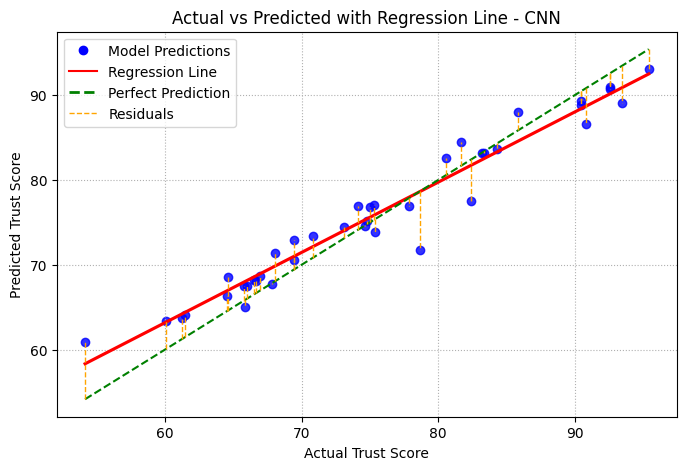

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Convert to 1-D arrays
y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred2).flatten()

plt.figure(figsize=(8, 5))

# Scatter + regression line with Seaborn
sns.regplot(
    x=y_test_arr,
    y=y_pred_arr,
    scatter_kws={ 'color':'blue'},
    line_kws={'color':'red'},
     ci=None
)

# Perfect prediction line
perfect_line, = plt.plot(
    [min(y_test_arr), max(y_test_arr)],
    [min(y_test_arr), max(y_test_arr)],
    color='green', linestyle='--', linewidth=1.5
)

# Draw vertical error lines from perfect line to predicted points
for x, y in zip(y_test_arr, y_pred_arr):
    plt.plot([x, x], [x, y], color='orange', linestyle='--', linewidth=1)

# Create legend manually
blue_points = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=6, label='Model Predictions')
reg_line = mlines.Line2D([], [], color='red', label='Regression Line')
perfect_line_proxy = mlines.Line2D([], [], color='green', linestyle='--', linewidth=2, label='Perfect Prediction')
error_lines_proxy = mlines.Line2D([], [], color='orange', linestyle='--', linewidth=1, label='Residuals')

plt.legend(handles=[blue_points, reg_line, perfect_line_proxy, error_lines_proxy], loc='best')

# Labels, title, grid
plt.xlabel("Actual Trust Score")
plt.ylabel("Predicted Trust Score")
plt.title("Actual vs Predicted with Regression Line - CNN")
plt.grid(True, linestyle=":")

plt.show()




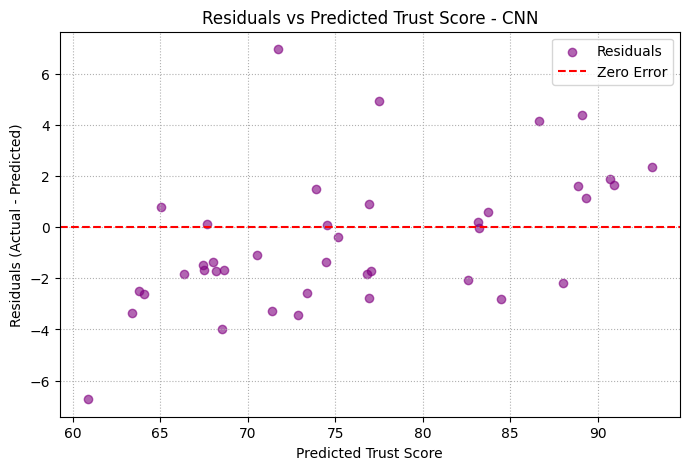

In [ ]:
# residuals = y_test_arr - y_pred_arr

# plt.figure(figsize=(8, 5))
# plt.scatter(y_pred_arr, residuals, alpha=0.6, color='purple')
# plt.axhline(y=0, color='red', linestyle='--')
# plt.xlabel("Predicted Trust Score")
# plt.ylabel("Residuals (Actual - Predicted)")
# plt.title("Residual Plot - CNN")
# plt.grid(True, linestyle=":")
# plt.show()


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred2).flatten()
residuals = y_test_arr - y_pred_arr

plt.figure(figsize=(8, 5))

# Scatter points for residuals
plt.scatter(y_pred_arr, residuals, alpha=0.6, color='purple', label='Residuals')

# Horizontal zero line
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error')

plt.xlabel("Predicted Trust Score")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted Trust Score - CNN")
plt.grid(True, linestyle=":")

# Add legend
plt.legend()

plt.show()


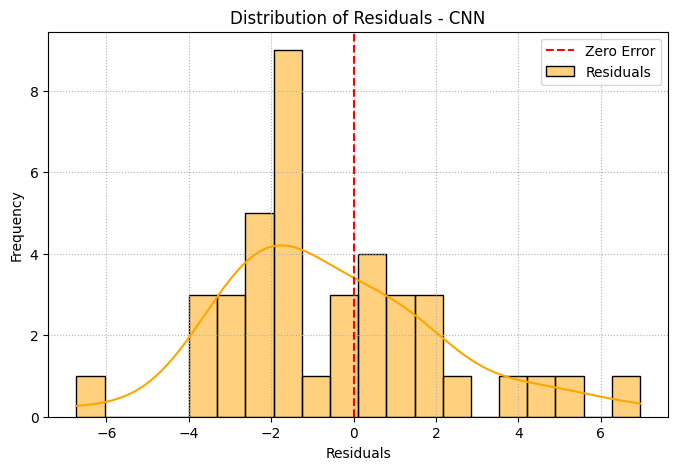

In [ ]:
# plt.figure(figsize=(8, 5))
# sns.histplot(residuals, bins=20, kde=True, color="orange")
# plt.axvline(x=0, color='red', linestyle='--')
# plt.xlabel("Residuals")
# plt.ylabel("Frequency")
# plt.title("Distribution of Residuals - CNN")
# plt.grid(True, linestyle=":")
# plt.show()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred2).flatten()
residuals = y_test_arr - y_pred_arr

plt.figure(figsize=(8, 5))

# Histogram with KDE
sns.histplot(residuals, bins=20, kde=True, color="orange", label="Residuals")

# Zero-error reference line
plt.axvline(x=0, color='red', linestyle='--', label="Zero Error")

plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals - CNN")
plt.grid(True, linestyle=":")

# Add legend
plt.legend()

plt.show()


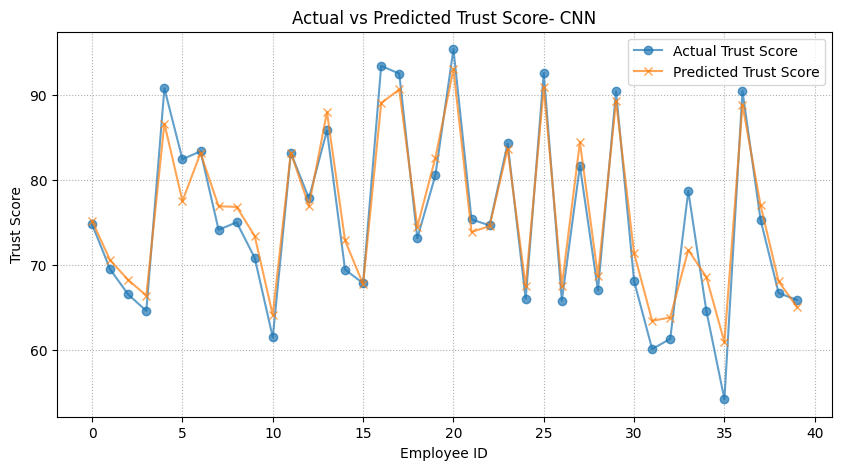

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred2).flatten()

plt.figure(figsize=(10,5))
plt.plot(y_test_arr, label="Actual Trust Score", marker="o", alpha=0.7)
plt.plot(y_pred_arr, label="Predicted Trust Score", marker="x", alpha=0.7)
plt.xlabel("Employee ID")
plt.ylabel("Trust Score")
plt.title("Actual vs Predicted Trust Score- CNN")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()

In [ ]:
cnn_model.save('trust_score_cnn.h5')

**Hybrid Model**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.optimizers import Adam

# --- Inputs ---
text_input = Input(shape=(X2_train.shape[1],), name='skill_input')  # Text: tokenized and padded skills
meta_input = Input(shape=(X1_train.shape[1],), name='meta_input')   # Meta: one-hot role + scores

# --- Shared Embedding ---
embedding = Embedding(input_dim=5000, output_dim=64, input_length=X2_train.shape[1])(text_input)

# --- LSTM Branch ---
lstm_out = LSTM(64)(embedding)

# --- CNN Branch ---
conv = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding)
cnn_out = GlobalMaxPooling1D()(conv)

# --- Combine text branches ---
text_features = Concatenate()([lstm_out, cnn_out])  # Shape: (LSTM + CNN outputs)

# --- Process meta features ---
meta_features = Dense(32, activation='relu')(meta_input)

# --- Combine all features ---
combined = Concatenate()([text_features, meta_features])
dense1 = Dense(64, activation='relu')(combined)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)  # Regression output (Trust Score)

# --- Build and compile model ---
hybrid_model = Model(inputs=[text_input, meta_input], outputs=output)
hybrid_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# --- Summary ---
hybrid_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ skill_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 64)   │    320,000 │ skill_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 96, 128)   │     41,088 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     33,024 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 192)       │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │        224 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 224)       │          0 │ concatenate_2[0]… │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │     14,400 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │      2,080 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │         33 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 410,849 (1.57 MB)

 Trainable params: 410,849 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history3 = hybrid_model.fit([X2_train, X1_train], y_train, validation_data=([X2_test, X1_test], y_test), epochs=100, batch_size=16)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 5713.8311 - mae: 74.9009 - val_loss: 5410.5317 - val_mae: 72.7903
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 5066.4087 - mae: 70.2736 - val_loss: 3157.8264 - val_mae: 55.1904
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 2099.6433 - mae: 42.7662 - val_loss: 273.3207 - val_mae: 14.1470
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 510.6066 - mae: 19.0281 - val_loss: 123.0980 - val_mae: 9.0758
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 175.3127 - mae: 10.4116 - val_loss: 203.8254 - val_mae: 11.0809
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 195.3695 - mae: 11.8832 - val_loss: 137.4938 - val_mae: 10.0946
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 140.5279 - mae: 10.0400 - val_loss: 121.6197 - val_mae: 9.0211
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 126.8400 - mae: 9.4290 - val_loss: 111.4299 - val_mae: 8.7705
Epoch 

In [ ]:
loss, mae = hybrid_model.evaluate([X2_test, X1_test], y_test)
print(f"Test MSE: {loss:.2f}")
print(f"Test MAE: {mae:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.7283 - mae: 0.6076
Test MSE: 0.74
Test MAE: 0.61


In [ ]:
from sklearn.metrics import r2_score

y_pred3 = hybrid_model.predict([X2_test, X1_test])
r2 = r2_score(y_test, y_pred3)
print(f"R² Score: {r2:.3f}")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
R² Score: 0.993


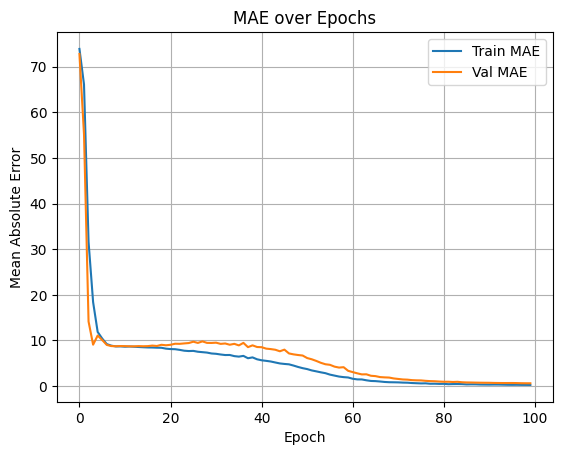

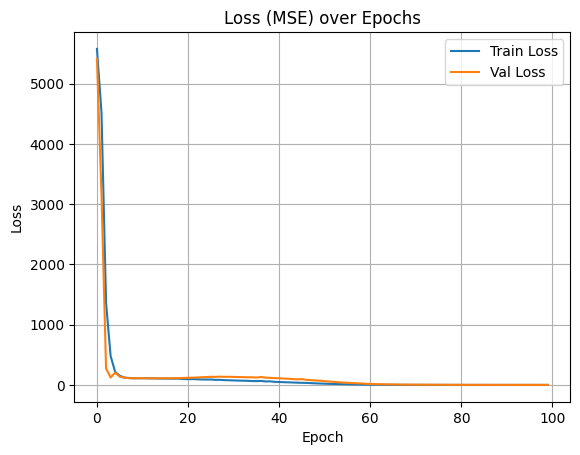

In [ ]:
import matplotlib.pyplot as plt

# Plot MAE
plt.plot(history3.history['mae'], label='Train MAE')
plt.plot(history3.history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.title('Loss (MSE) over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

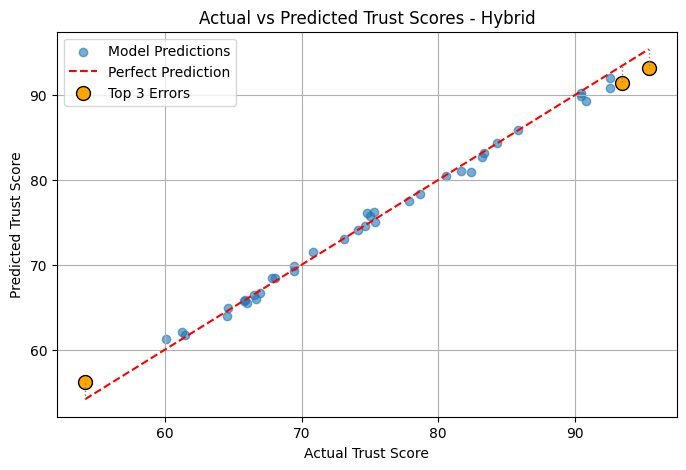

In [ ]:
# plt.figure(figsize=(8, 5))
# plt.scatter(y_test, y_pred3, alpha=0.6)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
# plt.xlabel('Actual Trust Score')
# plt.ylabel('Predicted Trust Score')
# plt.title('Actual vs Predicted Trust Scores')
# plt.grid(True)
# plt.show()

# import numpy as np
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 5))

# # Scatter plot
# plt.scatter(y_test, y_pred3, alpha=0.6, label="Predicted vs Actual")

# # Reference line (perfect prediction)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
#          color='red', linestyle='--', label="Perfect Prediction")

# # Residuals (distance from the line)
# residuals = np.abs(y_test - y_pred3)

# # Threshold for highlighting large displacements
# threshold = np.std(residuals)
# outliers = residuals > threshold

# # Highlight large displacement points
# plt.scatter(y_test[outliers], y_pred3[outliers],
#             color='orange', edgecolors='black', s=80,
#             label="Large Displacement")

# # Labels and title
# plt.xlabel('Actual Trust Score')
# plt.ylabel('Predicted Trust Score')
# plt.title('Actual vs Predicted Trust Scores')

# # Grid + legend
# plt.grid(True)
# plt.legend()

# plt.show()
# import numpy as np
# import matplotlib.pyplot as plt

# # Convert to 1-D NumPy arrays
# y_test_arr = np.array(y_test).flatten()
# y_pred3_arr = np.array(y_pred3).flatten()

# plt.figure(figsize=(8, 5))

# # Scatter plot
# plt.scatter(y_test_arr, y_pred3_arr, alpha=0.6, label="Model Predicttions")

# # Reference line (perfect prediction)
# plt.plot([min(y_test_arr), max(y_test_arr)],
#          [min(y_test_arr), max(y_test_arr)],
#          color='red', linestyle='--', label="Perfect Prediction")

# # Labels and title
# plt.xlabel('Actual Trust Score')
# plt.ylabel('Predicted Trust Score')
# plt.title('Actual vs Predicted Trust Scores - Hybrid')

# # Grid + legend
# plt.grid(True)
# plt.legend()

# plt.show()

import numpy as np
import matplotlib.pyplot as plt

# Convert to 1-D NumPy arrays
y_test_arr = np.array(y_test).flatten()
y_pred3_arr = np.array(y_pred3).flatten()

plt.figure(figsize=(8, 5))

# Scatter plot
plt.scatter(y_test_arr, y_pred3_arr, alpha=0.6, label="Model Predictions")

# Reference line (perfect prediction)
plt.plot([min(y_test_arr), max(y_test_arr)],
         [min(y_test_arr), max(y_test_arr)],
         color='red', linestyle='--', label="Perfect Prediction")

# Residuals (absolute error from perfect line)
residuals = np.abs(y_test_arr - y_pred3_arr)

# Find indices of top 3 farthest points
top3_idx = np.argsort(residuals)[-3:]

# Highlight top 3 outliers
plt.scatter(y_test_arr[top3_idx], y_pred3_arr[top3_idx],
            color='orange', edgecolors='black', s=100,
            label="Top 3 Errors")

# Draw dotted lines from each outlier to the reference line
for i in top3_idx:
    plt.plot([y_test_arr[i], y_test_arr[i]],
             [y_test_arr[i], y_pred3_arr[i]],
             color='gray', linestyle=':', linewidth=1)

# Labels and title
plt.xlabel('Actual Trust Score')
plt.ylabel('Predicted Trust Score')
plt.title('Actual vs Predicted Trust Scores - Hybrid')

# Grid + legend
plt.grid(True)
plt.legend()

plt.show()



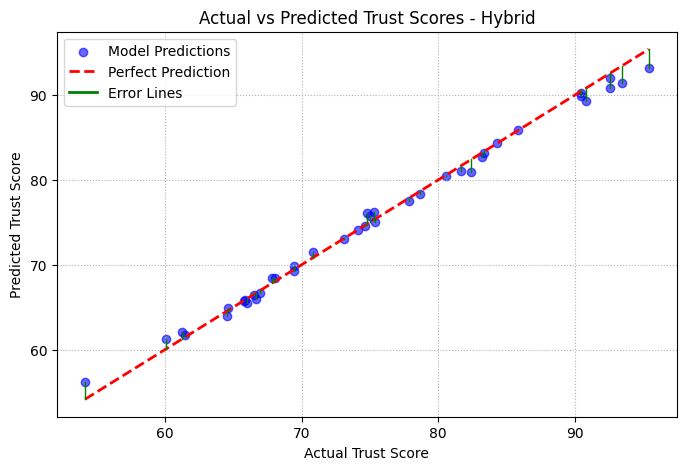

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Convert to 1-D NumPy arrays
y_test_arr = np.array(y_test).flatten()
y_pred3_arr = np.array(y_pred3).flatten()

plt.figure(figsize=(8, 5))

# Scatter plot
scatter = plt.scatter(y_test_arr, y_pred3_arr, alpha=0.6, color="blue", label="Model Predictions")

# Reference line (perfect prediction)
ref_line, = plt.plot([min(y_test_arr), max(y_test_arr)],
                     [min(y_test_arr), max(y_test_arr)],
                     color='red', linestyle='--', linewidth=2, label="Perfect Prediction")

# Residuals (absolute error from perfect line)
residuals = y_test_arr - y_pred3_arr

# Draw tangent/error lines for all points
for x, y in zip(y_test_arr, y_pred3_arr):
    plt.plot([x, x], [x, y], color="green", linewidth=1)

# Proxy line for legend
error_line = mlines.Line2D([], [], color="green", linewidth=2, label="Error Lines")

# Labels and title
plt.xlabel('Actual Trust Score')
plt.ylabel('Predicted Trust Score')
plt.title('Actual vs Predicted Trust Scores - Hybrid')

# Grid + legend
plt.grid(True, linestyle=":")
plt.legend(handles=[scatter, ref_line, error_line], loc="best")

plt.show()


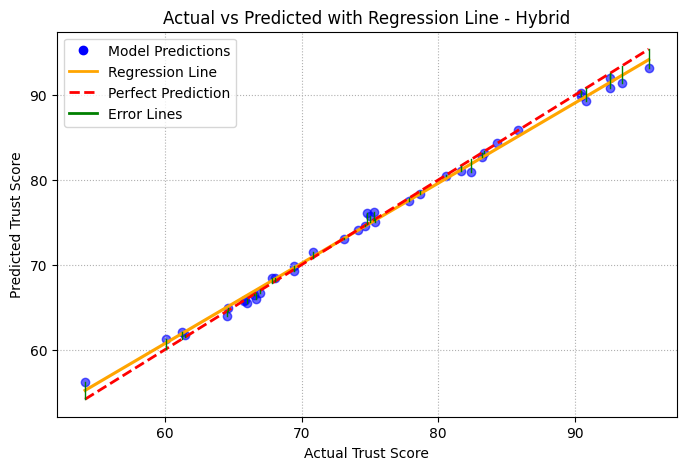

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Convert to 1-D NumPy arrays
y_test_arr = np.array(y_test).flatten()
y_pred3_arr = np.array(y_pred3).flatten()

plt.figure(figsize=(8, 5))

# Scatter plot + regression line (disable CI shading)
sns.regplot(
    x=y_test_arr,
    y=y_pred3_arr,
    scatter_kws={'color': 'blue', 'alpha': 0.6},
    line_kws={'color': 'orange'},
    ci=None
)

# Perfect prediction line
plt.plot([min(y_test_arr), max(y_test_arr)],
         [min(y_test_arr), max(y_test_arr)],
         color='red', linestyle='--', linewidth=2, label="Perfect Prediction")

# Draw vertical error lines for all points
for x, y in zip(y_test_arr, y_pred3_arr):
    plt.plot([x, x], [x, y], color="green", linewidth=1)

# Proxy handles for legend
blue_points = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=6, label='Model Predictions')
reg_line = mlines.Line2D([], [], color='orange', linewidth=2, label='Regression Line')
perfect_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
error_line = mlines.Line2D([], [], color="green", linewidth=2, label="Error Lines")

# Legend
plt.legend(handles=[blue_points, reg_line, perfect_line, error_line], loc="best")

# Labels and title
plt.xlabel("Actual Trust Score")
plt.ylabel("Predicted Trust Score")
plt.title("Actual vs Predicted with Regression Line - Hybrid")
plt.grid(True, linestyle=":")

plt.show()


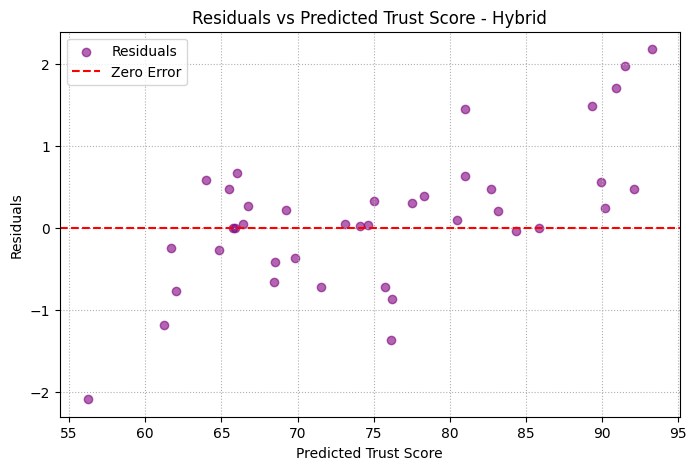

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# y_test_arr = np.array(y_test).flatten()
# y_pred3_arr = np.array(y_pred3).flatten()
# residuals = y_test_arr - y_pred3_arr

# plt.figure(figsize=(8, 5))
# plt.scatter(y_pred3_arr, residuals, alpha=0.6)
# plt.axhline(0, color="red", linestyle="--")
# plt.xlabel("Predicted Trust Score")
# plt.ylabel("Residuals")
# plt.title("Residuals vs Predicted - Hybrid")
# plt.grid(True, linestyle=":")
# plt.show()

import numpy as np
import matplotlib.pyplot as plt

y_test_arr = np.array(y_test).flatten()
y_pred3_arr = np.array(y_pred3).flatten()
residuals = y_test_arr - y_pred3_arr

plt.figure(figsize=(8, 5))

# Scatter points for residuals
plt.scatter(y_pred3_arr, residuals, alpha=0.6, color='purple', label='Residuals')

# Horizontal zero line
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error')

plt.xlabel("Predicted Trust Score")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Trust Score - Hybrid")
plt.grid(True, linestyle=":")

# Add legend
plt.legend()

plt.show()


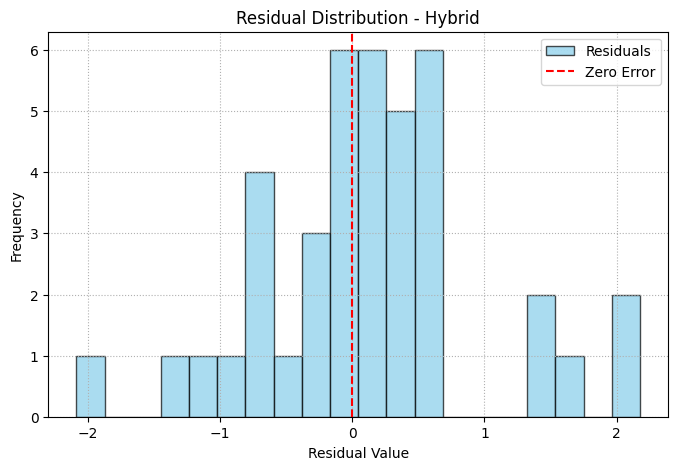

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# y_test_arr = np.array(y_test).flatten()
# y_pred3_arr = np.array(y_pred3).flatten()
# residuals = y_test_arr - y_pred3_arr

# plt.figure(figsize=(8, 5))
# plt.hist(residuals, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
# plt.axvline(0, color="red", linestyle="--")
# plt.xlabel("Residual Value")
# plt.ylabel("Frequency")
# plt.title("Residual Distribution - Hybrid")
# plt.grid(True, linestyle=":")
# plt.show()


import numpy as np
import matplotlib.pyplot as plt

y_test_arr = np.array(y_test).flatten()
y_pred3_arr = np.array(y_pred3).flatten()
residuals = y_test_arr - y_pred3_arr

plt.figure(figsize=(8, 5))

# Histogram of residuals
plt.hist(residuals, bins=20, color="skyblue", edgecolor="black", alpha=0.7, label="Residuals")

# Zero-error reference line
plt.axvline(0, color="red", linestyle="--", label="Zero Error")

plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Residual Distribution - Hybrid")
plt.grid(True, linestyle=":")

# Add legend
plt.legend()

plt.show()


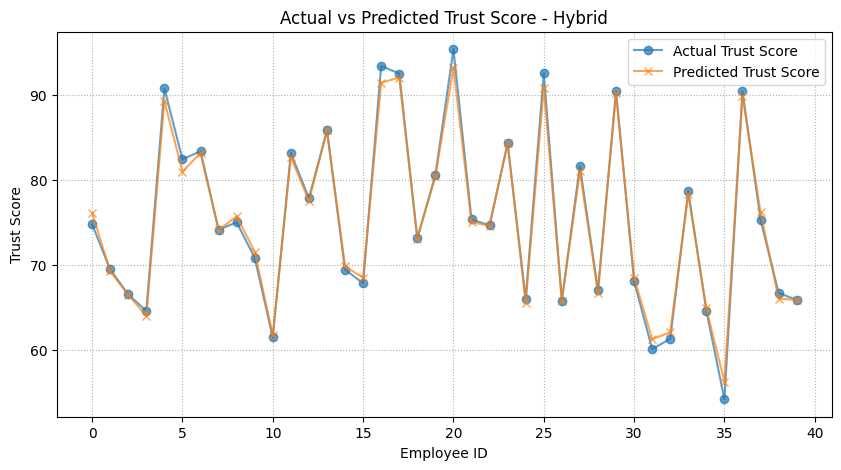

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y_test_arr = np.array(y_test).flatten()
y_pred3_arr = np.array(y_pred3).flatten()

plt.figure(figsize=(10, 5))
plt.plot(y_test_arr, label="Actual Trust Score", marker="o", alpha=0.7)
plt.plot(y_pred3_arr, label="Predicted Trust Score", marker="x", alpha=0.7)
plt.xlabel("Employee ID")
plt.ylabel("Trust Score")
plt.title("Actual vs Predicted Trust Score - Hybrid")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()


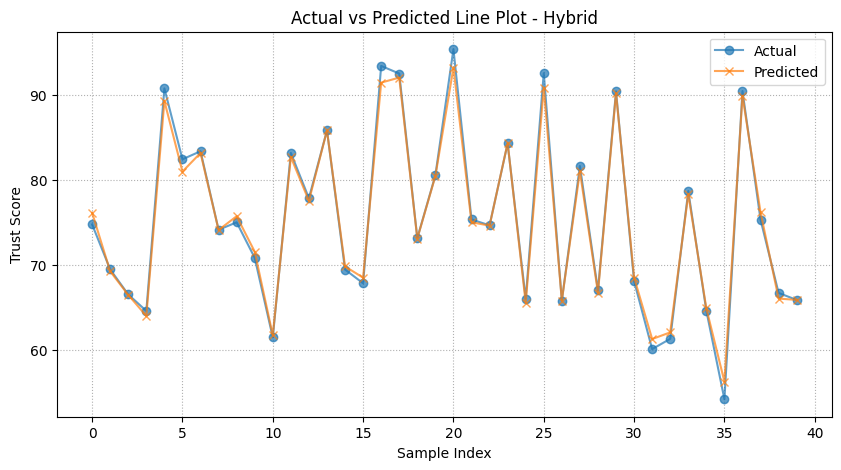

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y_test_arr = np.array(y_test).flatten()
y_pred3_arr = np.array(y_pred3).flatten()

plt.figure(figsize=(10, 5))
plt.plot(y_test_arr, label="Actual", marker="o", alpha=0.7)
plt.plot(y_pred3_arr, label="Predicted", marker="x", alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("Trust Score")
plt.title("Actual vs Predicted Line Plot - Hybrid")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()


In [ ]:
import pickle

In [ ]:
dic = {"x_test" : X_text, "y_test" : y_test, "y_pred" : y_pred3}

In [ ]:
model.save('trust_score_hybrid.h5')

In [ ]:
# def recommend_employees(task_title, handler_role, difficulty_level, required_skills, employees_df, model, role_encoder, scaler, tokenizer):

#     difficulty_map = {
#         'Beginner': (50, 65),
#         'Intermediate': (65, 80),
#         'Advanced': (80, 100)
#     }

#     if difficulty_level not in difficulty_map:
#         raise ValueError("Difficulty level must be one of: Beginner, Intermediate, Advanced")

#     comp_min, comp_max = difficulty_map[difficulty_level]

#     filtered = employees_df[employees_df['Role'] == handler_role].copy()

#     filtered = filtered[(filtered['Competence Score'] >= comp_min) & (filtered['Competence Score'] <= comp_max)]

#     if filtered.empty:
#         return "No employees match the role and competence criteria."

#     filtered['Skill Match Count'] = filtered['Skills'].apply(
#         lambda x: count_matching_skills(x, required_skills)
#     )
#     role_encoded = role_encoder.transform(filtered[['Role']])
#     numerical_features = scaler.transform(filtered[['Competence Score', 'Security Score']])
#     X_text = np.concatenate([role_encoded, numerical_features], axis=1)
#     sequences = tokenizer.texts_to_sequences(filtered['Skills'])
#     X_other = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

#     predicted_trust_scores = model.predict([X_other, X_text]).flatten()
#     filtered['Predicted Trust Score'] = predicted_trust_scores
#     filtered['Trust Score Difference'] = np.abs(filtered['Trust Score'] - predicted_trust_scores)

#     recommended = filtered.sort_values(by=['Predicted Trust Score', 'Skill Match Count'],ascending=[False, False]).head(3)
#     return recommended[['EmployeeID', 'Role', 'Skills', 'Competence Score',
#

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

def count_matching_skills(employee_skills, required_skills):
    emp_set = set(map(str.strip, employee_skills.upper().split(',')))
    req_set = set(map(str.strip, required_skills.upper().split(',')))
    return len(emp_set.intersection(req_set))

def recommend_employees(task_title, handler_role, difficulty_level, required_skills, employees_df, model, role_encoder, scaler, tokenizer):

    difficulty_map = {
        'Beginner': (50, 65),
        'Intermediate': (65, 80),
        'Advanced': (80, 100)
    }
    if difficulty_level not in difficulty_map:
        raise ValueError("Difficulty level must be one of: Beginner, Intermediate, Advanced")

    comp_min, comp_max = difficulty_map[difficulty_level]

    filtered = employees_df[employees_df['Role'] == handler_role].copy()
    filtered = filtered[(filtered['Competence Score'] >= comp_min) & (filtered['Competence Score'] <= comp_max)]
    if filtered.empty:
        return "No employees match the role and competence criteria."
    filtered['Skill Match Count'] = filtered['Skills'].apply(
        lambda x: count_matching_skills(x, required_skills)
    )

    role_encoded = role_encoder.transform(filtered[['Role']])
    numerical_features = scaler.transform(filtered[['Competence Score', 'Security Score']])
    X_text = np.concatenate([role_encoded, numerical_features], axis=1)

    sequences = tokenizer.texts_to_sequences(filtered['Skills'])
    X_other = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

    predicted_trust_scores = model.predict([X_other, X_text]).flatten()
    filtered['Predicted Trust Score'] = predicted_trust_scores
    filtered['Trust Score Difference'] = np.abs(filtered['Trust Score'] - predicted_trust_scores)
    filtered = filtered[filtered['Availability Status'] != 3]
    if filtered.empty:
        return "No employees match after filtering out Availability Status = 3."

    recommended = filtered.sort_values(by=['Predicted Trust Score', 'Skill Match Count'], ascending=[False, False]).head(3)

    columns_to_show = ['EmployeeID', 'Role', 'Skills', 'Competence Score', 'Trust Score',
                       'Predicted Trust Score', 'Skill Match Count', 'Task Completion',
                       'Meeting Deadline', 'Availability Status']

    return recommended[columns_to_show]



In [ ]:
from tabulate import tabulate

recommended = recommend_employees(
    task_title="Develop authentication and authorization modules",
    handler_role="back-end developer",
    difficulty_level="Advanced",
    required_skills="NODEJS, SQL, JAVASCRIPT",
    employees_df=employees,
    model=hybrid_model,
    role_encoder=role_encoder,
    scaler=scaler,
    tokenizer=tokenizer
)

# Truncate 'Skills' field for readability
recommended = recommended.copy()
recommended['Skills'] = recommended['Skills'].apply(lambda x: x[:40] + '...' if len(x) > 50 else x)

# Columns to display (with formatted labels)
rows = [
    ('Role', 'Role'),
    ('Skills', 'Skills'),
    ('Competence Score', 'Competence Score'),
    ('Skill Match Count', 'Skill Match Count'),
    ('Task Completion', 'Task Completion'),
    ('Meeting Deadline', 'Meeting Deadline'),
    ('Availability Status', 'Availability Status'),
    ('Trust Score', 'Trust Score'),
    ('Predicted Trust Score', 'Predicted Trust Score')
]

# Build the table as a list of rows
table_data = []

for label, col in rows:
    row = [label]
    for _, emp in recommended.iterrows():
        row.append(emp[col])
    table_data.append(row)

# Column headers: empty cell + Employee IDs
headers = [''] + [f"Employee {emp['EmployeeID']}" for _, emp in recommended.iterrows()]

# Print the side-by-side table
print(tabulate(table_data, headers=headers, tablefmt='github'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
|                       | Employee 137           | Employee 100            | Employee 193             |
|-----------------------|------------------------|-------------------------|--------------------------|
| Role                  | back-end developer     | back-end developer      | back-end developer       |
| Skills                | EXPRESSJS, SQL, NODEJS | EXPRESSJS, SQL, MONGODB | SQL, JAVASCRIPT, MONGODB |
| Competence Score      | 93.35361593            | 94.35432121             | 86.75355219              |
| Skill Match Count     | 2                      | 1                       | 2                        |
| Task Completion       | 94.246                 | 93.805                  | 81.333                   |
| Meeting Deadline      | 99.909                 | 90.213                  | 86.002                   |
| Availability Status   | 2                      | 2                       | 1                        |
| Trust Score           | 

In [ ]:
recommended_cnn = recommend_employees(
    task_title="Develop authentication and authorization modules",
    handler_role="back-end developer",
    difficulty_level="Advanced",
    required_skills="NODEJS, SQL, JAVASCRIPT",
    employees_df=employees,
    model=model,
    role_encoder=role_encoder,
    scaler=scaler,
    tokenizer=tokenizer
)
recommended_lstm = recommend_employees(
    task_title="Develop authentication and authorization modules",
    handler_role="back-end developer",
    difficulty_level="Advanced",
    required_skills="NODEJS, SQL, JAVASCRIPT",
    employees_df=employees,
    model=cnn_model,
    role_encoder=role_encoder,
    scaler=scaler,
    tokenizer=tokenizer
)
recommended_hybrid = recommend_employees(
    task_title="Develop authentication and authorization modules",
    handler_role="back-end developer",
    difficulty_level="Advanced",
    required_skills="NODEJS, SQL, JAVASCRIPT",
    employees_df=employees,
    model=hybrid_model,
    role_encoder=role_encoder,
    scaler=scaler,
    tokenizer=tokenizer
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


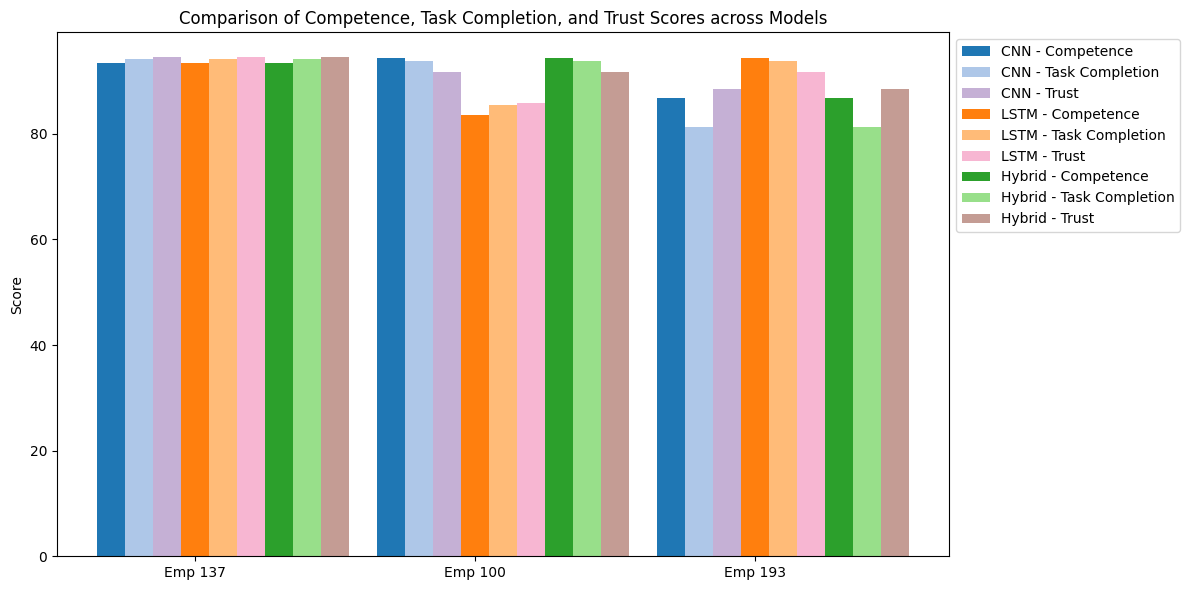

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Use top 3 employees from each model's recommendation
top_n = 3
models = {
    'CNN': recommended_cnn,
    'LSTM': recommended_lstm,
    'Hybrid': recommended_hybrid
}

# Scores to plot
metrics = ['Competence Score', 'Task Completion', 'Trust Score']
metric_labels = ['Competence', 'Task Completion', 'Trust']
colors = [
    ['#1f77b4', '#aec7e8', '#c5b0d5'],  # CNN
    ['#ff7f0e', '#ffbb78', '#f7b6d2'],  # LSTM
    ['#2ca02c', '#98df8a', '#c49c94']   # Hybrid
]
# Bar settings
bar_width = 0.2
x = np.arange(0, top_n * 2, 2)  # Positions for the employees

fig, ax = plt.subplots(figsize=(12, 6))

for i, (model_name, df) in enumerate(models.items()):
    offset = (i - 1) * (bar_width * len(metrics))  # shift group for each model
    for j, metric in enumerate(metrics):
        values = df[metric].values
        positions = x + offset + j * bar_width
        ax.bar(positions, values, bar_width, label=f"{model_name} - {metric_labels[j]}", color=colors[i][j])


# X-axis ticks (using employee IDs from hybrid model)
employee_ids = models['Hybrid']['EmployeeID'].tolist()
ax.set_xticks(x)
ax.set_xticklabels([f"Emp {eid}" for eid in employee_ids])

# Labels and legend
ax.set_title("Comparison of Competence, Task Completion, and Trust Scores across Models")
ax.set_ylabel("Score")
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()


COMPARISON


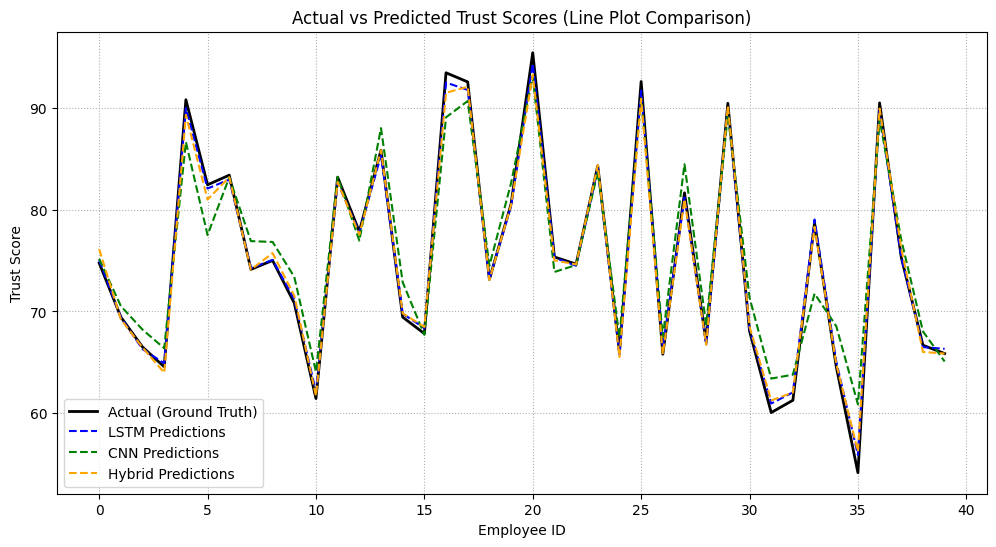

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert all to 1-D arrays
y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred).flatten()
y_pred2_arr = np.array(y_pred2).flatten()
y_pred3_arr = np.array(y_pred3).flatten()

plt.figure(figsize=(12, 6))
plt.plot(y_test_arr, label="Actual (Ground Truth)", color="black", linewidth=2)
plt.plot(y_pred_arr, label="LSTM Predictions", linestyle="--", color="blue")
plt.plot(y_pred2_arr, label="CNN Predictions", linestyle="--", color="green")
plt.plot(y_pred3_arr, label="Hybrid Predictions", linestyle="--", color="orange")

plt.xlabel("Employee ID")
plt.ylabel("Trust Score")
plt.title("Actual vs Predicted Trust Scores (Line Plot Comparison)")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()


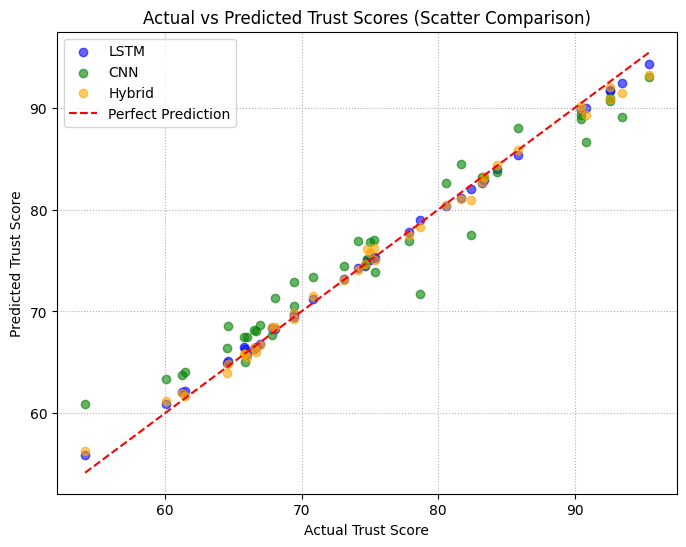

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_arr, y_pred_arr, alpha=0.6, label="LSTM", color="blue")
plt.scatter(y_test_arr, y_pred2_arr, alpha=0.6, label="CNN", color="green")
plt.scatter(y_test_arr, y_pred3_arr, alpha=0.6, label="Hybrid", color="orange")

# Perfect prediction reference line
plt.plot([min(y_test_arr), max(y_test_arr)],
         [min(y_test_arr), max(y_test_arr)],
         color="red", linestyle="--", label="Perfect Prediction")

plt.xlabel("Actual Trust Score")
plt.ylabel("Predicted Trust Score")
plt.title("Actual vs Predicted Trust Scores (Scatter Comparison)")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()


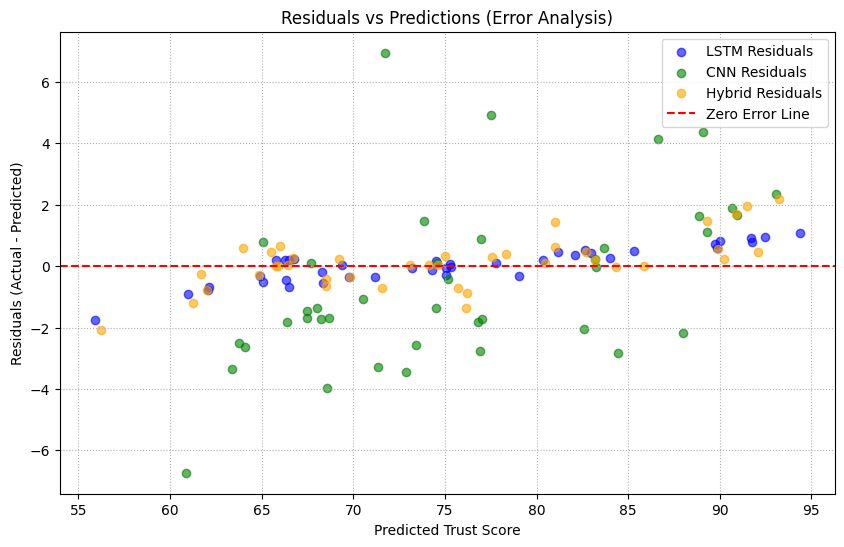

In [ ]:
res1 = y_test_arr - y_pred_arr
res2 = y_test_arr - y_pred2_arr
res3 = y_test_arr - y_pred3_arr

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_arr, res1, alpha=0.6, color="blue", label="LSTM Residuals")
plt.scatter(y_pred2_arr, res2, alpha=0.6, color="green", label="CNN Residuals")
plt.scatter(y_pred3_arr, res3, alpha=0.6, color="orange", label="Hybrid Residuals")

plt.axhline(0, color="red", linestyle="--", label="Zero Error Line")

plt.xlabel("Predicted Trust Score")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predictions (Error Analysis)")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()


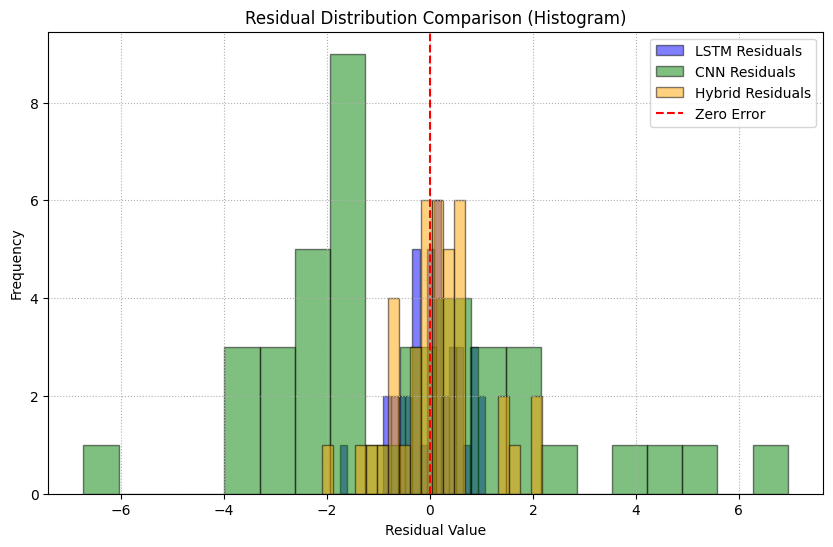

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(res1, bins=20, alpha=0.5, label="LSTM Residuals", color="blue", edgecolor="black")
plt.hist(res2, bins=20, alpha=0.5, label="CNN Residuals", color="green", edgecolor="black")
plt.hist(res3, bins=20, alpha=0.5, label="Hybrid Residuals", color="orange", edgecolor="black")

plt.axvline(0, color="red", linestyle="--", label="Zero Error")

plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Residual Distribution Comparison (Histogram)")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()


/tmp/ipython-input-4283867488.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([res1, res2, res3], labels=["LSTM", "CNN", "Hybrid"], patch_artist=True)


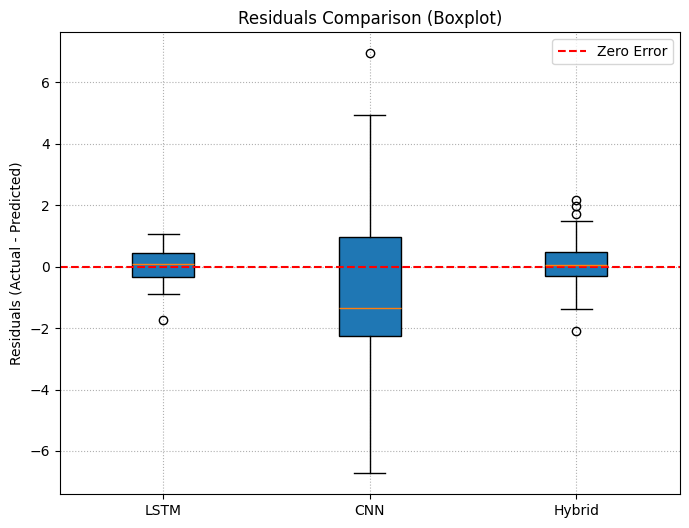

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot([res1, res2, res3], labels=["LSTM", "CNN", "Hybrid"], patch_artist=True)

plt.axhline(0, color="red", linestyle="--", label="Zero Error")

plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals Comparison (Boxplot)")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()


In [ ]:
import pickle

# Bundle everything into a dictionary
results = {
    "y_test": y_test,
    "y_pred": y_pred,
    "y_pred2": y_pred2,
    "y_pred3": y_pred3
}

# Save to pickle file
with open("model_predictions.pkl", "wb") as f:
    pickle.dump(results, f)

print("✅ Predictions saved to model_predictions.pkl")


✅ Predictions saved to model_predictions.pkl


# data creation for Comparison of results when assigned with trust and without trust

In [2]:
import pandas as pd

In [3]:
employees = pd.read_csv('/content/employee_dataset_updated-completion.csv')
tasks = pd.read_csv('/content/df2_aligned.csv')

In [4]:
display(employees.head())
display(tasks.head())

,EmployeeID,Role,Skills,Competence Score,Security Score,Task Completion,Meeting Deadline,Trust Score,Profile Text,Availability Status
0,1,back-end developer,"JAVASCRIPT, EXPRESSJS, SQL",68.727006,97.535715,86.099,83.772,83.13,"Back-End Developer skilled in JAVASCRIPT, EXPR...",1
1,2,front-end developer,"CSS, HTML, JAVASCRIPT",86.599697,79.932924,84.247,83.751,83.27,"Front-End Developer skilled in CSS, HTML, JAVA...",1
2,3,back-end developer,"SQL, MONGODB, JAVASCRIPT",57.800932,57.799726,51.112,58.748,57.80,"Back-End Developer skilled in SQL, MONGODB, JA...",1
3,4,back-end developer,"JAVASCRIPT, NODEJS, SQL",52.904181,93.308807,78.713,73.000,73.11,"Back-End Developer skilled in JAVASCRIPT, NODE...",1
4,5,back-end developer,"SQL, NODEJS, EXPRESSJS",80.055751,85.403629,86.751,86.900,82.73,"Back-End Developer skilled in SQL, NODEJS, EXP...",1


,TaskID,Task Title,Difficulty,Handler Role,t1,t2,t3,AssignedEmployeeID
0,1,"Replace the content of the file ""mynewfileAdva...",Intermediate,back-end developer,JAVASCRIPT,NODEJS,EXPRESSJS,120
1,2,Test all the server,Intermediate,tester,MANUAL TESTING,NaN,NaN,117
2,3,Create HTML forms,Intermediate,front-end developer,HTML,CSS,BOOTSTRAP,184
3,4,Test all the handling,Advanced,tester,MANUAL TESTING,NaN,NaN,49
4,5,Create a function that will select random name...,Advanced,front-end developer,HTML,CSS,JAVASCRIPT,111


# Task
Join the `employees` and `tasks` dataframes on columns with similar data and display the top rows of the resulting dataframe.

## Examine potential join columns

### Subtask:
Inspect columns in both dataframes that are likely candidates for joining based on similar data content, focusing on columns like `Role`.


**Reasoning**:
Print the column names of both dataframes to identify potential join keys.



In [5]:
print("Columns in employees dataframe:", employees.columns.tolist())
print("Columns in tasks dataframe:", tasks.columns.tolist())

Columns in employees dataframe: ['EmployeeID', 'Role', 'Skills', 'Competence Score', 'Security Score', 'Task Completion', 'Meeting Deadline', 'Trust Score', 'Profile Text', 'Availability Status']
Columns in tasks dataframe: ['TaskID', 'Task Title', 'Difficulty', 'Handler Role', 't1', 't2', 't3', 'AssignedEmployeeID']


## Identify join key

### Subtask:
Based on the examination, determine the most suitable column(s) to use as the join key.


**Reasoning**:
Compare the unique values in 'Role' and 'Handler Role' columns, and 'EmployeeID' and 'AssignedEmployeeID' columns to determine suitable join keys.



In [6]:
print("Unique values in 'Role' from employees dataset:")
display(employees['Role'].unique())

print("\nUnique values in 'Handler Role' from tasks dataset:")
display(tasks['Handler Role'].unique())

print("\nUnique values in 'EmployeeID' from employees dataset:")
display(employees['Skills'].unique())

print("\nUnique values in 'AssignedEmployeeID' from tasks dataset:")
display(tasks['Required Skills'].unique())

Unique values in 'Role' from employees dataset:


array(['back-end developer', 'front-end developer', 'designer', 'tester'],
      dtype=object)


Unique values in 'Handler Role' from tasks dataset:


array(['back-end developer', 'tester', 'front-end developer', 'designer'],
      dtype=object)


Unique values in 'EmployeeID' from employees dataset:


array(['JAVASCRIPT, EXPRESSJS, SQL', 'CSS, HTML, JAVASCRIPT',
       'SQL, MONGODB, JAVASCRIPT', 'JAVASCRIPT, NODEJS, SQL',
       'SQL, NODEJS, EXPRESSJS', 'ADOBE XD, PHOTOSHOP, ILLUSTRATOR',
       'MANUAL TESTING, JUNIT, AUTOMATION',
       'SELENIUM, MANUAL TESTING, JUNIT', 'EXPRESSJS, SQL, MONGODB',
       'MANUAL TESTING, SELENIUM, AUTOMATION',
       'MONGODB, JAVASCRIPT, EXPRESSJS',
       'SELENIUM, JUNIT, MANUAL TESTING', 'JAVASCRIPT, NODEJS, MONGODB',
       'NODEJS, JAVASCRIPT, SQL', 'JUNIT, SELENIUM, AUTOMATION',
       'JAVASCRIPT, BOOTSTRAP, HTML', 'MANUAL TESTING, SELENIUM, JUNIT',
       'CSS, REACT, BOOTSTRAP', 'AUTOMATION, SELENIUM, JUNIT',
       'ILLUSTRATOR, FIGMA, PHOTOSHOP',
       'PHOTOSHOP, ADOBE XD, GOOGLE FONTS', 'CSS, JAVASCRIPT, REACT',
       'GOOGLE FONTS, PHOTOSHOP, ADOBE XD', 'CSS, REACT, HTML',
       'JAVASCRIPT, NODEJS, EXPRESSJS', 'REACT, HTML, CSS',
       'GOOGLE FONTS, PHOTOSHOP, ILLUSTRATOR',
       'SELENIUM, MANUAL TESTING, AUTOMATION',
    


Unique values in 'AssignedEmployeeID' from tasks dataset:


KeyError: 'Required Skills'

In [7]:
# Extract 'Skills' from employees and 't1', 't2', 't3' from tasks
skills_df = employees[['Skills']].copy()
task_skills_df = tasks[['t1', 't2', 't3']].copy()

# Combine 't1', 't2', 't3' into a single comma-separated string in tasks_df
tasks['Required Skills'] = tasks[['t1', 't2', 't3']].fillna('').agg(','.join, axis=1)
# Remove leading/trailing commas and handle cases with only NaNs
tasks['Required Skills'] = tasks['Required Skills'].str.replace(',,', ',').str.strip(',').replace('', np.nan)


# Display the modified tasks dataframe with the new 'Required Skills' column
print("Tasks dataframe with combined skills:")
display(tasks.head())

Tasks dataframe with combined skills:


,TaskID,Task Title,Difficulty,Handler Role,t1,t2,t3,AssignedEmployeeID,Required Skills
0,1,"Replace the content of the file ""mynewfileAdva...",Intermediate,back-end developer,JAVASCRIPT,NODEJS,EXPRESSJS,120,"JAVASCRIPT,NODEJS,EXPRESSJS"
1,2,Test all the server,Intermediate,tester,MANUAL TESTING,NaN,NaN,117,MANUAL TESTING
2,3,Create HTML forms,Intermediate,front-end developer,HTML,CSS,BOOTSTRAP,184,"HTML,CSS,BOOTSTRAP"
3,4,Test all the handling,Advanced,tester,MANUAL TESTING,NaN,NaN,49,MANUAL TESTING
4,5,Create a function that will select random name...,Advanced,front-end developer,HTML,CSS,JAVASCRIPT,111,"HTML,CSS,JAVASCRIPT"


In [8]:
employees[employees['Role'] == 'front-end developer'].loc[117]

,117
EmployeeID,118
Role,front-end developer
Skills,"CSS, BOOTSTRAP, HTML"
Competence Score,59.762149
Security Score,86.122606
Task Completion,72.785
Meeting Deadline,78.779
Trust Score,72.94
Profile Text,"Front-End Developer skilled in CSS, BOOTSTRAP,..."
Availability Status,1


In [9]:
tasks[tasks['Handler Role'] == 'front-end developer']

,TaskID,Task Title,Difficulty,Handler Role,t1,t2,t3,AssignedEmployeeID,Required Skills
2,3,Create HTML forms,Intermediate,front-end developer,HTML,CSS,BOOTSTRAP,184,"HTML,CSS,BOOTSTRAP"
4,5,Create a function that will select random name...,Advanced,front-end developer,HTML,CSS,JAVASCRIPT,111,"HTML,CSS,JAVASCRIPT"
7,8,Create HTML tables,Advanced,front-end developer,HTML,CSS,NaN,97,"HTML,CSS"
10,11,Create and insert a Favicon,Intermediate,front-end developer,HTML,CSS,NaN,190,"HTML,CSS"
11,12,Create an increement and decreement button,Beginner,front-end developer,HTML,CSS,JAVASCRIPT,89,"HTML,CSS,JAVASCRIPT"
12,13,Create a list where every number is the sum of...,Intermediate,front-end developer,HTML,CSS,JAVASCRIPT,179,"HTML,CSS,JAVASCRIPT"
13,14,Switch the starting values that are held in tw...,Beginner,front-end developer,HTML,CSS,JAVASCRIPT,39,"HTML,CSS,JAVASCRIPT"
14,15,Create a fucntion for optimizing the new images,Advanced,front-end developer,HTML,CSS,JAVASCRIPT,121,"HTML,CSS,JAVASCRIPT"
15,16,Put image element,Beginner,front-end developer,HTML,CSS,NaN,139,"HTML,CSS"
16,17,Create a bullet list,Beginner,front-end developer,HTML,CSS,NaN,69,"HTML,CSS"


In [10]:
# Merge dataframes on 'AssignedEmployeeID' from tasks and 'EmployeeID' from employees
# Using a left merge to keep all tasks
merged_df = tasks.merge(employees, left_on='AssignedEmployeeID', right_on='EmployeeID', how='left')

# Display the complete merged dataframe
print("Merged dataframe (tasks merged with employees based on Assigned Employee ID):")
display(merged_df)

# Display info about the merged dataframe to check for missing values after merge
print("\nInfo about the merged dataframe:")
merged_df.info()

Merged dataframe (tasks merged with employees based on Assigned Employee ID):


,TaskID,Task Title,Difficulty,Handler Role,t1,t2,t3,AssignedEmployeeID,Required Skills,EmployeeID,Role,Skills,Competence Score,Security Score,Task Completion,Meeting Deadline,Trust Score,Profile Text,Availability Status
0,1,"Replace the content of the file ""mynewfileAdva...",Intermediate,back-end developer,JAVASCRIPT,NODEJS,EXPRESSJS,120,"JAVASCRIPT,NODEJS,EXPRESSJS",120,back-end developer,"MONGODB, SQL, EXPRESSJS",82.273615,58.855534,77.663,78.888,70.56,"Back-End Developer skilled in MONGODB, SQL, EX...",1
1,2,Test all the server,Intermediate,tester,MANUAL TESTING,NaN,NaN,117,MANUAL TESTING,117,tester,"MANUAL TESTING, JUNIT, AUTOMATION",78.845194,74.625885,75.370,76.073,76.74,"Tester skilled in MANUAL TESTING, JUNIT, AUTOM...",2
2,3,Create HTML forms,Intermediate,front-end developer,HTML,CSS,BOOTSTRAP,184,"HTML,CSS,BOOTSTRAP",184,front-end developer,"REACT, HTML, BOOTSTRAP",98.059528,95.267532,91.671,92.855,96.66,"Front-End Developer skilled in REACT, HTML, BO...",2
3,4,Test all the handling,Advanced,tester,MANUAL TESTING,NaN,NaN,49,MANUAL TESTING,49,tester,"MANUAL TESTING, SELENIUM, JUNIT",76.136641,71.377051,76.725,73.619,73.76,"Tester skilled in MANUAL TESTING, SELENIUM, JUNIT",1
4,5,Create a function that will select random name...,Advanced,front-end developer,HTML,CSS,JAVASCRIPT,111,"HTML,CSS,JAVASCRIPT",111,front-end developer,"CSS, REACT, JAVASCRIPT",82.880645,78.415430,85.962,82.169,80.65,"Front-End Developer skilled in CSS, REACT, JAV...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,107,Test all the components,Advanced,tester,MANUAL TESTING,NaN,NaN,86,MANUAL TESTING,86,tester,"AUTOMATION, SELENIUM, JUNIT",83.878218,50.829391,63.202,60.384,67.35,"Tester skilled in AUTOMATION, SELENIUM, JUNIT",1
107,108,Test all the UI elements,Beginner,tester,MANUAL TESTING,NaN,NaN,131,MANUAL TESTING,131,tester,"SELENIUM, JUNIT, MANUAL TESTING",80.750361,99.502693,90.983,98.255,90.13,"Tester skilled in SELENIUM, JUNIT, MANUAL TESTING",2
108,109,Create checkboxes,Beginner,designer,HTML,CSS,NaN,124,"HTML,CSS",124,designer,"FIGMA, ADOBE XD, GOOGLE FONTS",71.409207,98.332741,84.294,87.048,84.87,"Designer skilled in FIGMA, ADOBE XD, GOOGLE FONTS",1
109,110,Create a contact me form,Advanced,front-end developer,HTML,CSS,BOOTSTRAP,145,"HTML,CSS,BOOTSTRAP",145,front-end developer,"REACT, JAVASCRIPT, CSS",64.327063,79.541663,77.764,78.656,71.93,"Front-End Developer skilled in REACT, JAVASCRI...",1



Info about the merged dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TaskID               111 non-null    int64  
 1   Task Title           111 non-null    object 
 2   Difficulty           111 non-null    object 
 3   Handler Role         111 non-null    object 
 4   t1                   111 non-null    object 
 5   t2                   76 non-null     object 
 6   t3                   68 non-null     object 
 7   AssignedEmployeeID   111 non-null    int64  
 8   Required Skills      111 non-null    object 
 9   EmployeeID           111 non-null    int64  
 10  Role                 111 non-null    object 
 11  Skills               111 non-null    object 
 12  Competence Score     111 non-null    float64
 13  Security Score       111 non-null    float64
 14  Task Completion      111 non-null    float64
 15  Meetin

In [11]:
# Show rows with any NaN values in the merged dataframe
rows_with_nan = merged_df[merged_df.isnull().any(axis=1)]

print("Rows in the merged dataframe with missing values:")
display(len(rows_with_nan))

Rows in the merged dataframe with missing values:


43

In [12]:
merged_df.keys()

Index(['TaskID', 'Task Title', 'Difficulty', 'Handler Role', 't1', 't2', 't3',
       'AssignedEmployeeID', 'Required Skills', 'EmployeeID', 'Role', 'Skills',
       'Competence Score', 'Security Score', 'Task Completion',
       'Meeting Deadline', 'Trust Score', 'Profile Text',
       'Availability Status'],
      dtype='object')

In [13]:
merged_df[['TaskID', 'Task Title', 'Handler Role',
       'AssignedEmployeeID', 'Required Skills', 'Role', 'Skills',
       'Task Completion',
        'Trust Score',
]].to_csv('tasks_assignment_results_with trust.csv')

In [14]:
# merged_df.to_csv('tasks_assignment_results_with trust.csv')

# creating task ssignemt without trust results

In [20]:
import pandas as pd
import numpy as np

# --- Assume you already have employees_df and tasks_df loaded ---

# Make a copy of the tasks df to avoid overwriting the original
tasks_random_assign_df = tasks.copy()

# Create a mapping: role -> list of employee IDs with that role
role_to_employee_ids = (
    employees.groupby('Role')['EmployeeID']
    .apply(list)
    .to_dict()
)

# Function to randomly assign an employee ID based on Handler Role
def assign_random_employee(handler_role):
    if handler_role in role_to_employee_ids:
        return np.random.choice(role_to_employee_ids[handler_role])
    else:
        return np.nan  # In case no employee matches that role

# Apply the random assignment to the tasks copy
tasks_random_assign_df['NewAssignedEmployeeID'] = tasks_random_assign_df['Handler Role'].apply(assign_random_employee)

# Merge tasks with employees based on the new random assignment
merged_random_assign_df = tasks_random_assign_df.merge(
    employees,
    left_on='NewAssignedEmployeeID',
    right_on='EmployeeID',
    how='left',
    suffixes=('_task', '_employee')
)

# Optional: create a Required Skills column for clarity
merged_random_assign_df['Required Skills'] = (
    tasks_random_assign_df[['t1', 't2', 't3']]
    .astype(str)
    .agg(lambda x: ','.join([i for i in x if i != 'nan']), axis=1)
)

# Reorder columns if needed (example order)
cols_order = [
    'TaskID', 'Task Title', 'Difficulty', 'Handler Role',
    't1', 't2', 't3', 'NewAssignedEmployeeID', 'Required Skills',
    'EmployeeID', 'Role', 'Skills', 'Competence Score', 'Security Score',
    'Task Completion', 'Meeting Deadline', 'Trust Score', 'Profile Text', 'Availability Status'
]

# merged_random_assign_df = merged_random_assign_df[cols_order]

print("✅ New merged DataFrame created with random employee assignments.")
(merged_random_assign_df.head())


✅ New merged DataFrame created with random employee assignments.


,TaskID,Task Title,Difficulty,Handler Role,t1,t2,t3,AssignedEmployeeID,Required Skills,NewAssignedEmployeeID,EmployeeID,Role,Skills,Competence Score,Security Score,Task Completion,Meeting Deadline,Trust Score,Profile Text,Availability Status
0,1,"Replace the content of the file ""mynewfileAdva...",Intermediate,back-end developer,JAVASCRIPT,NODEJS,EXPRESSJS,120,"JAVASCRIPT,NODEJS,EXPRESSJS",170,170,back-end developer,"NODEJS, MONGODB, SQL",73.708691,54.891708,60.978,62.789,64.30,"Back-End Developer skilled in NODEJS, MONGODB,...",1
1,2,Test all the server,Intermediate,tester,MANUAL TESTING,NaN,NaN,117,MANUAL TESTING,34,34,tester,"AUTOMATION, SELENIUM, MANUAL TESTING",57.046211,90.109849,76.396,78.651,73.58,"Tester skilled in AUTOMATION, SELENIUM, MANUAL...",1
2,3,Create HTML forms,Intermediate,front-end developer,HTML,CSS,BOOTSTRAP,184,"HTML,CSS,BOOTSTRAP",39,39,front-end developer,"BOOTSTRAP, HTML, REACT",88.563517,53.702233,74.086,74.941,71.13,"Front-End Developer skilled in BOOTSTRAP, HTML...",1
3,4,Test all the handling,Advanced,tester,MANUAL TESTING,NaN,NaN,49,MANUAL TESTING,11,11,tester,"MANUAL TESTING, SELENIUM, AUTOMATION",80.592645,56.974693,68.967,69.491,68.78,"Tester skilled in MANUAL TESTING, SELENIUM, AU...",1
4,5,Create a function that will select random name...,Advanced,front-end developer,HTML,CSS,JAVASCRIPT,111,"HTML,CSS,JAVASCRIPT",189,189,front-end developer,"BOOTSTRAP, JAVASCRIPT, HTML",92.243766,51.163597,78.706,77.353,71.70,"Front-End Developer skilled in BOOTSTRAP, JAVA...",1


In [21]:
# import numpy as np

# # --- Assume merged_random_assign_df and merged_df are already defined ---

# # Drop 'Meeting Deadline' from merged_random_assign_df
# merged_random_assign_df = merged_random_assign_df.drop(columns=['Meeting Deadline'], errors='ignore')

# # Task Completion logic:
# # Generate random numbers to define how we adjust task completion
# def adjust_task_completion(row):
#     task_completion_merged = merged_df.loc[merged_df['TaskID'] == row['TaskID'], 'Task Completion'].values[0]

#     # 80% of values less than, 13% equal, 7% greater
#     rand_val = np.random.rand()

#     if rand_val < 0.80:
#         # 80% - Make it less than the value from merged_df
#         return task_completion_merged * np.random.uniform(0.5, 0.99)
#     elif rand_val < 0.93:
#         # 13% - Make it equal to the value from merged_df
#         return task_completion_merged
#     else:
#         # 7% - Make it greater than the value from merged_df
#         return task_completion_merged * np.random.uniform(1.01, 1.5)

# # Apply the adjustment to the 'Task Completion' column in merged_random_assign_df
# merged_random_assign_df['Task Completion'] = merged_random_assign_df.apply(adjust_task_completion, axis=1)

# # Print out the updated DataFrame's Task Completion column
# print("✅ Task Completion column updated with random adjustments.")
# print(merged_random_assign_df[['TaskID', 'Task Completion']].head())

import numpy as np
import pandas as pd

# --- Assuming merged_random_assign_df and merged_df are already defined ---

# Function to adjust Task Completion
def adjust_task_completion(row):
    task_completion_merged = merged_df.loc[merged_df['TaskID'] == row['TaskID'], 'Task Completion'].values[0]

    rand_val = np.random.rand()

    if rand_val < 0.80:
        # 80% - Make it less than the value from merged_df
        return task_completion_merged * np.random.uniform(0.5, 0.99)
    elif rand_val < 0.93:
        # 13% - Make it equal to the value from merged_df
        return task_completion_merged
    else:
        # 7% - Make it greater than the value from merged_df
        return task_completion_merged * np.random.uniform(1.01, 1.5)

# Function to adjust Meeting Deadline
def adjust_meeting_deadline(row):
    meeting_deadline_merged = merged_df.loc[merged_df['TaskID'] == row['TaskID'], 'Meeting Deadline'].values[0]

    rand_val = np.random.rand()

    if rand_val < 0.80:
        # 80% - Make it less than the value from merged_df
        return meeting_deadline_merged * np.random.uniform(0.5, 0.99)
    elif rand_val < 0.93:
        # 13% - Make it equal to the value from merged_df
        return meeting_deadline_merged
    else:
        # 7% - Make it greater than the value from merged_df
        return meeting_deadline_merged * np.random.uniform(1.01, 1.5)

# Apply adjustments to Task Completion and Meeting Deadline
merged_random_assign_df['Task Completion'] = merged_random_assign_df.apply(adjust_task_completion, axis=1)
merged_random_assign_df['Meeting Deadline'] = merged_random_assign_df.apply(adjust_meeting_deadline, axis=1)

# Print out the updated DataFrame's Task Completion and Meeting Deadline columns
print("✅ Task Completion and Meeting Deadline columns updated with random adjustments.")
print(merged_random_assign_df[['TaskID', 'Task Completion', 'Meeting Deadline']].head())



✅ Task Completion and Meeting Deadline columns updated with random adjustments.
   TaskID  Task Completion  Meeting Deadline
0       1        46.372478         63.269691
1       2        75.370000         43.604419
2       3        53.677330         82.683319
3       4        58.588544         39.501858
4       5        92.114988         42.460423


In [23]:
print(merged_random_assign_df.head()[['Task Completion', 'Meeting Deadline']])
print(merged_df.head()[['Task Completion' ,'Meeting Deadline']])


   Task Completion  Meeting Deadline
0        46.372478         63.269691
1        75.370000         43.604419
2        53.677330         82.683319
3        58.588544         39.501858
4        92.114988         42.460423
   Task Completion  Meeting Deadline
0           77.663            78.888
1           75.370            76.073
2           91.671            92.855
3           76.725            73.619
4           85.962            82.169


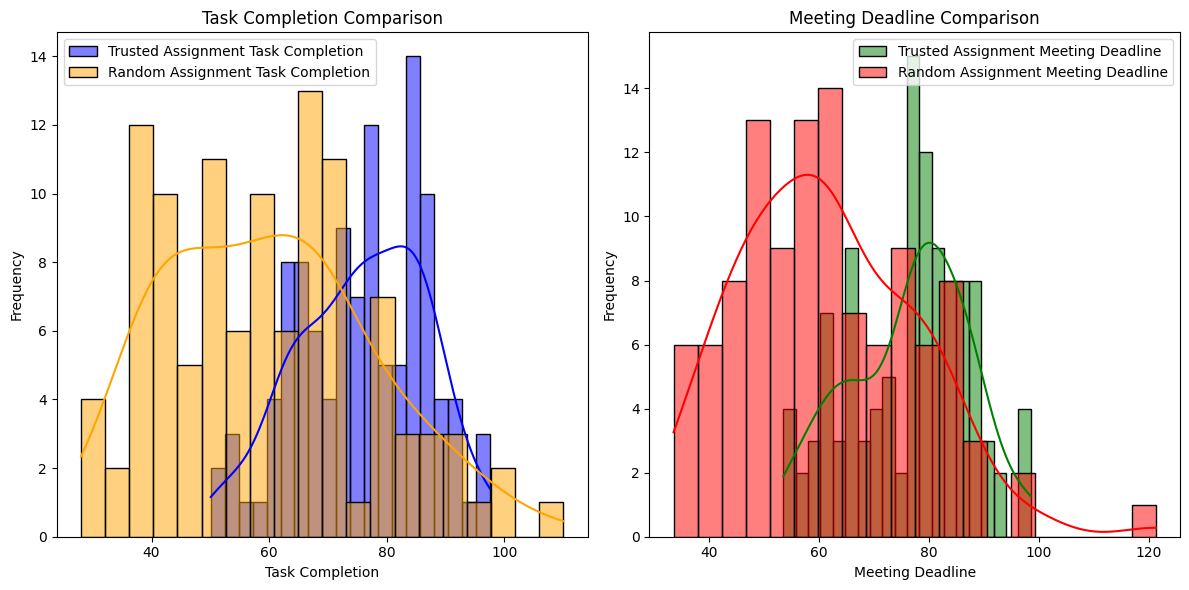

/tmp/ipython-input-4087846444.py:33: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[merged_df['Task Completion'], merged_random_assign_df['Task Completion']],


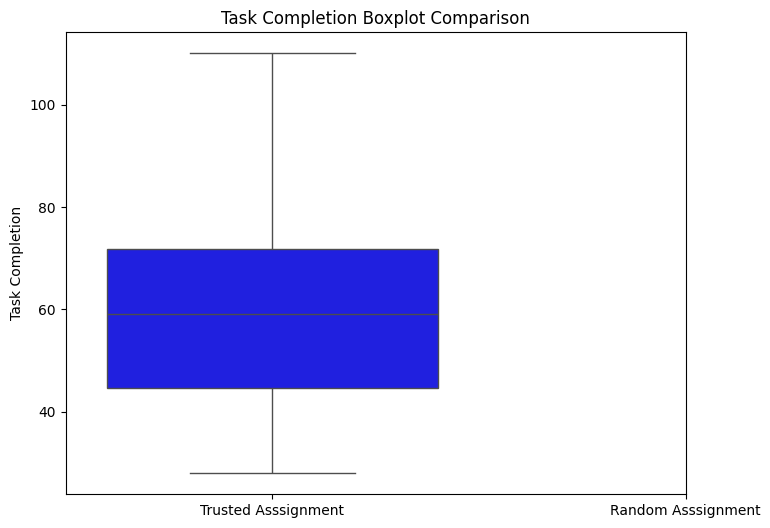

/tmp/ipython-input-4087846444.py:42: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[merged_df['Meeting Deadline'], merged_random_assign_df['Meeting Deadline']],


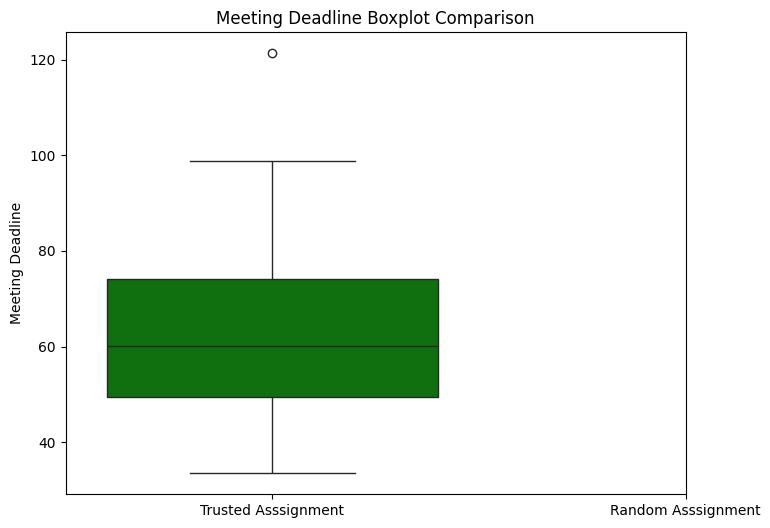


--- Task Completion Statistics ---
merged_df: Mean = 75.76574774774774, Median = 77.414
merged_random_assign_df: Mean = 59.8612381961016, Median = 59.06213137638558

--- Meeting Deadline Statistics ---
merged_df: Mean = 76.33262162162164, Median = 77.927
merged_random_assign_df: Mean = 61.48082317460449, Median = 60.140599722872004


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assuming merged_df and merged_random_assign_df are already defined ---

# Analyze and Compare Task Completion
# 1. Plot histograms of 'Task Completion' in both DataFrames
plt.figure(figsize=(12, 6))

# Task Completion Distribution Comparison
plt.subplot(1, 2, 1)
sns.histplot(merged_df['Task Completion'], color='blue', label='Trusted Assignment Task Completion', kde=True, bins=20)
sns.histplot(merged_random_assign_df['Task Completion'], color='orange', label='Random Assignment Task Completion', kde=True, bins=20)
plt.title('Task Completion Comparison')
plt.xlabel('Task Completion')
plt.ylabel('Frequency')
plt.legend()

# Analyze and Compare Meeting Deadlines
plt.subplot(1, 2, 2)
sns.histplot(merged_df['Meeting Deadline'], color='green', label='Trusted Assignment Meeting Deadline', kde=True, bins=20)
sns.histplot(merged_random_assign_df['Meeting Deadline'], color='red', label='Random Assignment Meeting Deadline', kde=True, bins=20)
plt.title('Meeting Deadline Comparison')
plt.xlabel('Meeting Deadline')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Boxplot Comparison for Task Completion
plt.figure(figsize=(8, 6))
sns.boxplot(data=[merged_df['Task Completion'], merged_random_assign_df['Task Completion']],
            palette=["blue", "orange"])
plt.xticks([0, 1], ['Trusted Asssignment', 'Random Asssignment'])
plt.title('Task Completion Boxplot Comparison')
plt.ylabel('Task Completion')
plt.show()

# Boxplot Comparison for Meeting Deadline
plt.figure(figsize=(8, 6))
sns.boxplot(data=[merged_df['Meeting Deadline'], merged_random_assign_df['Meeting Deadline']],
            palette=["green", "red"])
plt.xticks([0, 1], ['Trusted Asssignment', 'Random Asssignment'])
plt.title('Meeting Deadline Boxplot Comparison')
plt.ylabel('Meeting Deadline')
plt.show()

# Additional statistics: Comparing means and medians
task_completion_stats = {
    'merged_df': {
        'mean': merged_df['Task Completion'].mean(),
        'median': merged_df['Task Completion'].median()
    },
    'merged_random_assign_df': {
        'mean': merged_random_assign_df['Task Completion'].mean(),
        'median': merged_random_assign_df['Task Completion'].median()
    }
}

meeting_deadline_stats = {
    'merged_df': {
        'mean': merged_df['Meeting Deadline'].mean(),
        'median': merged_df['Meeting Deadline'].median()
    },
    'merged_random_assign_df': {
        'mean': merged_random_assign_df['Meeting Deadline'].mean(),
        'median': merged_random_assign_df['Meeting Deadline'].median()
    }
}

# Print statistical comparison
print("\n--- Task Completion Statistics ---")
print(f"merged_df: Mean = {task_completion_stats['merged_df']['mean']}, Median = {task_completion_stats['merged_df']['median']}")
print(f"merged_random_assign_df: Mean = {task_completion_stats['merged_random_assign_df']['mean']}, Median = {task_completion_stats['merged_random_assign_df']['median']}")

print("\n--- Meeting Deadline Statistics ---")
print(f"merged_df: Mean = {meeting_deadline_stats['merged_df']['mean']}, Median = {meeting_deadline_stats['merged_df']['median']}")
print(f"merged_random_assign_df: Mean = {meeting_deadline_stats['merged_random_assign_df']['mean']}, Median = {meeting_deadline_stats['merged_random_assign_df']['median']}")



--- Checking Task Completion Data ---
merged_df Task Completion: Min = 50.073 , Max = 97.487
merged_random_assign_df_clean Task Completion: Min = 28.0152001288006 , Max = 110.01202296270326

--- Checking for NaN or Empty Values ---
merged_df Task Completion NaN count: 0
merged_random_assign_df_clean Task Completion NaN count: 0

--- Sample of Data for merged_random_assign_df_clean ---
   Task Completion  Meeting Deadline
0        46.372478         63.269691
1        75.370000         43.604419
2        53.677330         82.683319
3        58.588544         39.501858
4        92.114988         42.460423

--- Count of Non-NaN Values ---
merged_df Task Completion count: 111
merged_random_assign_df_clean Task Completion count: 111


/tmp/ipython-input-3205524622.py:31: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[merged_df['Task Completion'], merged_random_assign_df_clean['Task Completion']],


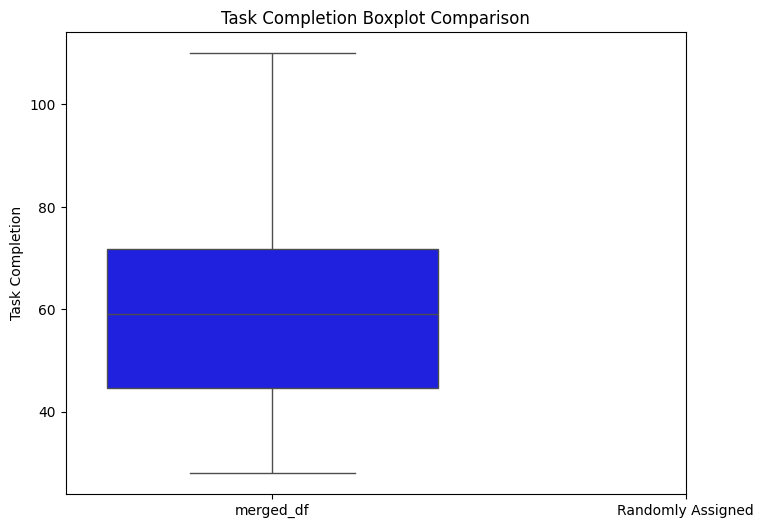

/tmp/ipython-input-3205524622.py:40: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[merged_df['Meeting Deadline'], merged_random_assign_df_clean['Meeting Deadline']],


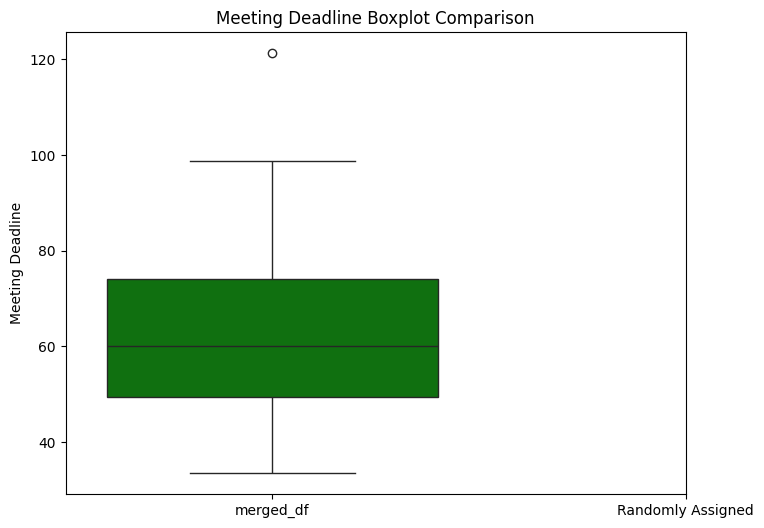

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns


# Check if data exists in the relevant columns for merged_random_assign_df_clean
print("\n--- Checking Task Completion Data ---")
print("merged_df Task Completion: Min =", merged_df['Task Completion'].min(), ", Max =", merged_df['Task Completion'].max())
print("merged_random_assign_df_clean Task Completion: Min =", merged_random_assign_df_clean['Task Completion'].min(), ", Max =", merged_random_assign_df_clean['Task Completion'].max())

# Check for empty or NaN values in both Task Completion and Meeting Deadline columns
print("\n--- Checking for NaN or Empty Values ---")
print("merged_df Task Completion NaN count:", merged_df['Task Completion'].isna().sum())
print("merged_random_assign_df_clean Task Completion NaN count:", merged_random_assign_df_clean['Task Completion'].isna().sum())

# Print a sample of data to inspect
print("\n--- Sample of Data for merged_random_assign_df_clean ---")
print(merged_random_assign_df_clean[['Task Completion', 'Meeting Deadline']].head())

# Now let's check the overall count of non-NaN values
print("\n--- Count of Non-NaN Values ---")
print("merged_df Task Completion count:", merged_df['Task Completion'].count())
print("merged_random_assign_df_clean Task Completion count:", merged_random_assign_df_clean['Task Completion'].count())

###########=====================================================================

# Ensure no missing values in Task Completion and Meeting Deadline columns
merged_random_assign_df_clean = merged_random_assign_df.dropna(subset=['Task Completion', 'Meeting Deadline'])

# Boxplot Comparison for Task Completion
plt.figure(figsize=(8, 6))
sns.boxplot(data=[merged_df['Task Completion'], merged_random_assign_df_clean['Task Completion']],
            palette=["blue", "orange"])  # Two colors for two boxplots
plt.xticks([0, 1], ['merged_df', 'Randomly Assigned'])
plt.title('Task Completion Boxplot Comparison')
plt.ylabel('Task Completion')
plt.show()

# Boxplot Comparison for Meeting Deadline
plt.figure(figsize=(8, 6))
sns.boxplot(data=[merged_df['Meeting Deadline'], merged_random_assign_df_clean['Meeting Deadline']],
            palette=["green", "red"])  # Two colors for two boxplots
plt.xticks([0, 1], ['merged_df', 'Randomly Assigned'])
plt.title('Meeting Deadline Boxplot Comparison')
plt.ylabel('Meeting Deadline')
plt.show()


/tmp/ipython-input-3196376168.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Source', y='Task Completion', data=task_completion_data, palette=["blue", "orange"])


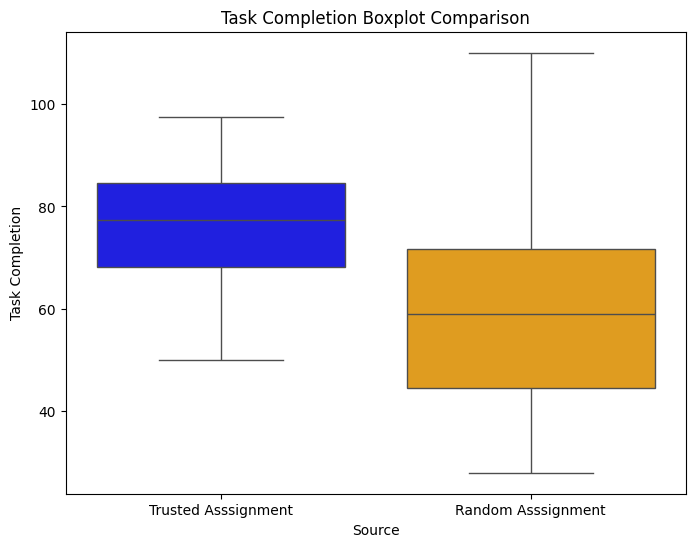

/tmp/ipython-input-3196376168.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Source', y='Meeting Deadline', data=meeting_deadline_data, palette=["green", "red"])


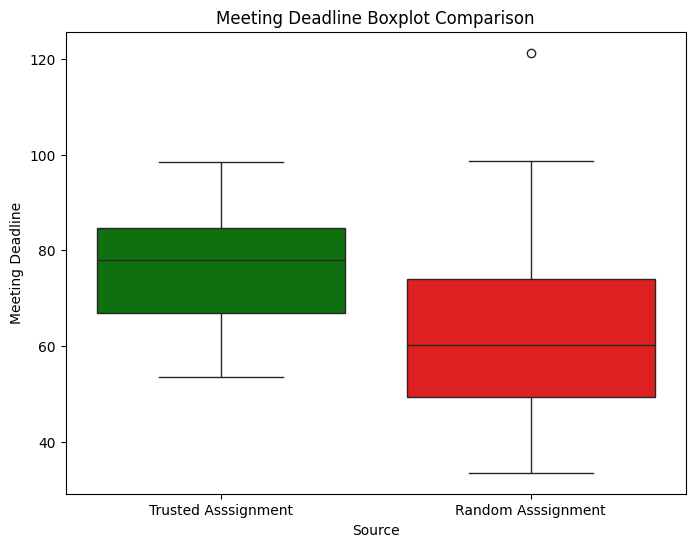

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine merged_df and merged_random_assign_df_clean into a long format DataFrame
task_completion_data = pd.concat([
    pd.DataFrame({'Task Completion': merged_df['Task Completion'], 'Source': 'Trusted Asssignment'}),
    pd.DataFrame({'Task Completion': merged_random_assign_df_clean['Task Completion'], 'Source': 'Random Asssignment'})
])

# Boxplot Comparison for Task Completion (long format DataFrame)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Source', y='Task Completion', data=task_completion_data, palette=["blue", "orange"])
plt.title('Task Completion Boxplot Comparison')
plt.ylabel('Task Completion')
plt.show()

# Combine Meeting Deadline data into a long format DataFrame
meeting_deadline_data = pd.concat([
    pd.DataFrame({'Meeting Deadline': merged_df['Meeting Deadline'], 'Source': 'Trusted Asssignment'}),
    pd.DataFrame({'Meeting Deadline': merged_random_assign_df_clean['Meeting Deadline'], 'Source': 'Random Asssignment'})
])

# Boxplot Comparison for Meeting Deadline (long format DataFrame)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Source', y='Meeting Deadline', data=meeting_deadline_data, palette=["green", "red"])
plt.title('Meeting Deadline Boxplot Comparison')
plt.ylabel('Meeting Deadline')
plt.show()



--- Task Completion Statistics ---
merged_df: Mean = 75.76574774774774, Median = 77.414
merged_random_assign_df: Mean = 59.8612381961016, Median = 59.06213137638558

--- Meeting Deadline Statistics ---
merged_df: Mean = 76.33262162162164, Median = 77.927
merged_random_assign_df: Mean = 61.48082317460449, Median = 60.140599722872004


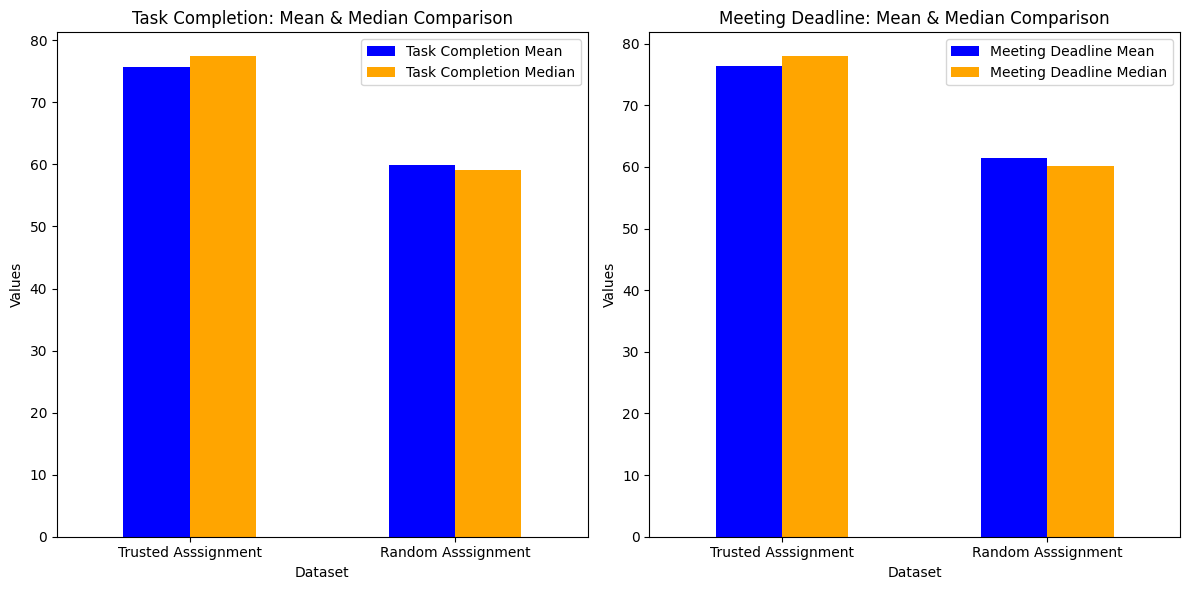

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assuming merged_df and merged_random_assign_df are already defined ---

# Calculate statistical values for Task Completion and Meeting Deadline
task_completion_stats = {
    'merged_df': {
        'mean': merged_df['Task Completion'].mean(),
        'median': merged_df['Task Completion'].median()
    },
    'merged_random_assign_df': {
        'mean': merged_random_assign_df['Task Completion'].mean(),
        'median': merged_random_assign_df['Task Completion'].median()
    }
}

meeting_deadline_stats = {
    'merged_df': {
        'mean': merged_df['Meeting Deadline'].mean(),
        'median': merged_df['Meeting Deadline'].median()
    },
    'merged_random_assign_df': {
        'mean': merged_random_assign_df['Meeting Deadline'].mean(),
        'median': merged_random_assign_df['Meeting Deadline'].median()
    }
}

# Print the statistical values
print("\n--- Task Completion Statistics ---")
print(f"merged_df: Mean = {task_completion_stats['merged_df']['mean']}, Median = {task_completion_stats['merged_df']['median']}")
print(f"merged_random_assign_df: Mean = {task_completion_stats['merged_random_assign_df']['mean']}, Median = {task_completion_stats['merged_random_assign_df']['median']}")

print("\n--- Meeting Deadline Statistics ---")
print(f"merged_df: Mean = {meeting_deadline_stats['merged_df']['mean']}, Median = {meeting_deadline_stats['merged_df']['median']}")
print(f"merged_random_assign_df: Mean = {meeting_deadline_stats['merged_random_assign_df']['mean']}, Median = {meeting_deadline_stats['merged_random_assign_df']['median']}")

# Step 1: Prepare data for visualization
stats_df = pd.DataFrame({
    'Dataset': ['Trusted Asssignment', 'Random Asssignment'],
    'Task Completion Mean': [task_completion_stats['merged_df']['mean'], task_completion_stats['merged_random_assign_df']['mean']],
    'Task Completion Median': [task_completion_stats['merged_df']['median'], task_completion_stats['merged_random_assign_df']['median']],
    'Meeting Deadline Mean': [meeting_deadline_stats['merged_df']['mean'], meeting_deadline_stats['merged_random_assign_df']['mean']],
    'Meeting Deadline Median': [meeting_deadline_stats['merged_df']['median'], meeting_deadline_stats['merged_random_assign_df']['median']]
})

# Step 2: Plot Mean and Median for Task Completion and Meeting Deadline
plt.figure(figsize=(12, 6))

# Plot for Task Completion (Mean & Median)
plt.subplot(1, 2, 1)
stats_df.plot(x='Dataset', y=['Task Completion Mean', 'Task Completion Median'], kind='bar', ax=plt.gca(), color=['blue', 'orange'])
plt.title('Task Completion: Mean & Median Comparison')
plt.ylabel('Values')
plt.xlabel('Dataset')
plt.xticks(rotation=0)

# Plot for Meeting Deadline (Mean & Median)
plt.subplot(1, 2, 2)
stats_df.plot(x='Dataset', y=['Meeting Deadline Mean', 'Meeting Deadline Median'], kind='bar', ax=plt.gca(), color=['blue', 'orange'])
plt.title('Meeting Deadline: Mean & Median Comparison')
plt.ylabel('Values')
plt.xlabel('Dataset')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


/tmp/ipython-input-517344580.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=role_groups, x='Role', y=('Task Completion Diff', 'mean'), palette="coolwarm")
/tmp/ipython-input-517344580.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=role_groups, x='Role', y=('Meeting Deadline Diff', 'mean'), palette="coolwarm")


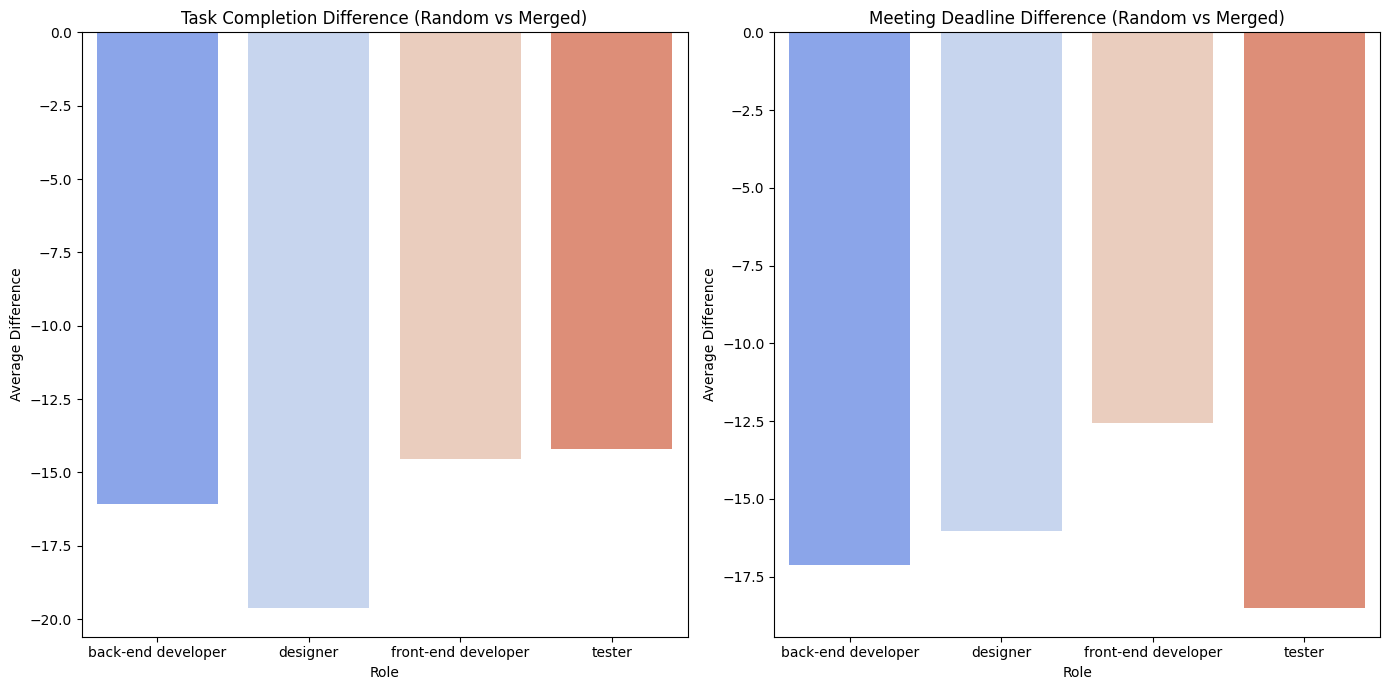

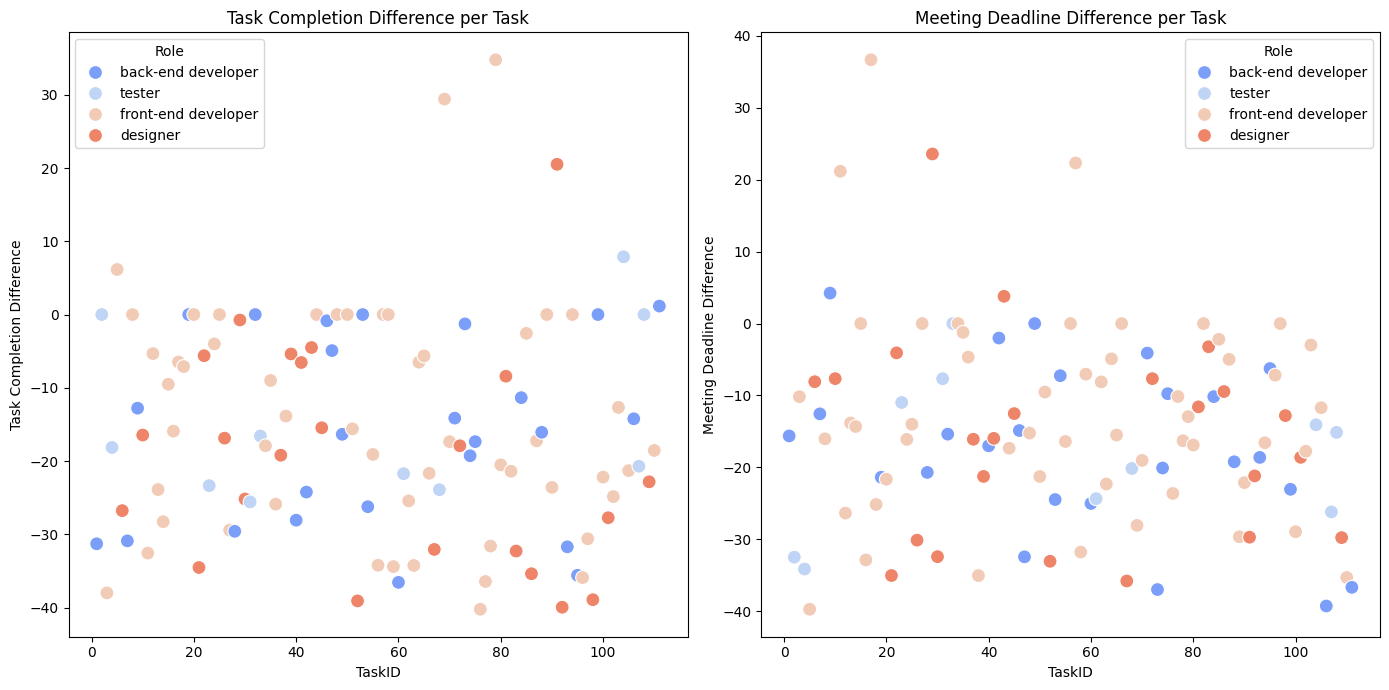


--- Difference Statistics ---
                    Task Completion Diff                                   \
                                    mean        std        min        max   
Role                                                                        
back-end developer            -16.061619  12.827548 -36.553197   1.155633   
designer                      -19.620169  15.130411 -39.944788  20.508259   
front-end developer           -14.537983  15.807266 -40.222331  34.768023   
tester                        -14.208308  12.101801 -25.571823   7.881061   

                    Meeting Deadline Diff                                   
                                     mean        std        min        max  
Role                                                                        
back-end developer             -17.138314  11.535197 -39.253773   4.233309  
designer                       -16.023482  14.298981 -35.780740  23.569924  
front-end developer            -12.574736  1

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assuming merged_df and merged_random_assign_df are already defined ---

# Step 1: Calculate the difference for Task Completion and Meeting Deadline
merged_random_assign_df['Task Completion Diff'] = merged_random_assign_df['Task Completion'] - \
    merged_df['Task Completion']
merged_random_assign_df['Meeting Deadline Diff'] = merged_random_assign_df['Meeting Deadline'] - \
    merged_df['Meeting Deadline']

# Step 2: Group by Role to compare the differences across roles
role_groups = merged_random_assign_df.groupby('Role').agg({
    'Task Completion Diff': ['mean', 'std'],
    'Meeting Deadline Diff': ['mean', 'std']
}).reset_index()

# Step 3: Plot the differences for Task Completion and Meeting Deadline
plt.figure(figsize=(14, 7))

# Plot Task Completion Difference
plt.subplot(1, 2, 1)
sns.barplot(data=role_groups, x='Role', y=('Task Completion Diff', 'mean'), palette="coolwarm")
plt.title('Task Completion Difference (Random vs Trusted Asssignment)')
plt.ylabel('Average Difference')
plt.xlabel('Role')

# Plot Meeting Deadline Difference
plt.subplot(1, 2, 2)
sns.barplot(data=role_groups, x='Role', y=('Meeting Deadline Diff', 'mean'), palette="coolwarm")
plt.title('Meeting Deadline Difference (Random vs Trusted Asssignment)')
plt.ylabel('Average Difference')
plt.xlabel('Role')

plt.tight_layout()
plt.show()

# Step 4: Plot the distribution of differences per Task (scatter plot)
plt.figure(figsize=(14, 7))

# Task Completion Difference per TaskID
plt.subplot(1, 2, 1)
sns.scatterplot(data=merged_random_assign_df, x='TaskID', y='Task Completion Diff', hue='Role', palette='coolwarm', s=100)
plt.title('Task Completion Difference per Task')
plt.xlabel('TaskID')
plt.ylabel('Task Completion Difference')

# Meeting Deadline Difference per TaskID
plt.subplot(1, 2, 2)
sns.scatterplot(data=merged_random_assign_df, x='TaskID', y='Meeting Deadline Diff', hue='Role', palette='coolwarm', s=100)
plt.title('Meeting Deadline Difference per Task')
plt.xlabel('TaskID')
plt.ylabel('Meeting Deadline Difference')

plt.tight_layout()
plt.show()

# Optional: Print summary statistics for differences
print("\n--- Difference Statistics ---")
print(merged_random_assign_df.groupby('Role').agg({
    'Task Completion Diff': ['mean', 'std', 'min', 'max'],
    'Meeting Deadline Diff': ['mean', 'std', 'min', 'max']
}))



--- Absolute Difference Statistics ---
                    Task Completion Diff                                  \
                                    mean        std       min        max   
Role                                                                       
back-end developer             16.154070  12.706043  0.000000  36.553197   
designer                       21.403496  12.346876  0.746297  39.944788   
front-end developer            17.192040  12.807689  0.000000  40.222331   
tester                         15.784520   9.691529  0.000000  25.571823   

                    Meeting Deadline Diff                                  
                                     mean        std       min        max  
Role                                                                       
back-end developer              17.476979  10.993150  0.000000  39.253773  
designer                        18.402293  10.901653  3.227228  35.780740  
front-end developer             15.598826  11.0

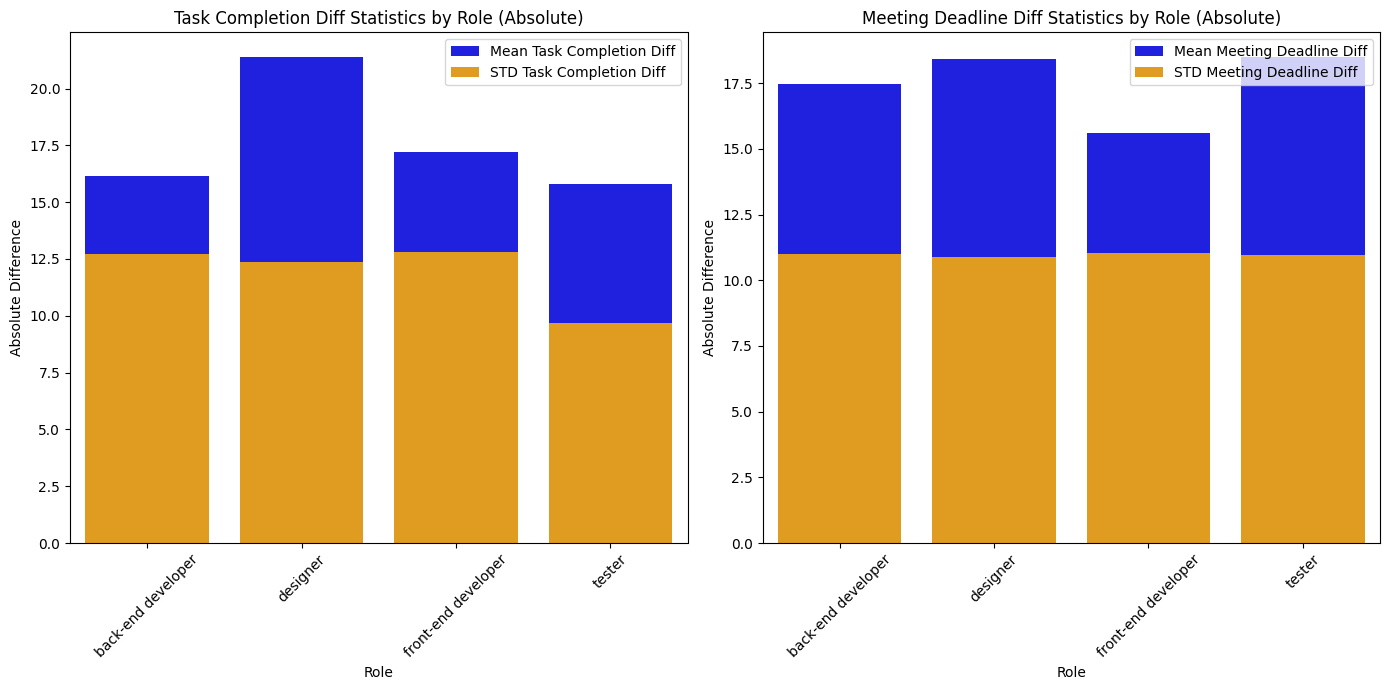

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming merged_df and merged_random_assign_df are already loaded
# and merged_random_assign_df has a 'Role' column as well.

# Step 1: Compute Absolute Differences for Task Completion and Meeting Deadline
merged_random_assign_df['Task Completion Diff'] = abs(merged_random_assign_df['Task Completion'] - merged_df['Task Completion'])
merged_random_assign_df['Meeting Deadline Diff'] = abs(merged_random_assign_df['Meeting Deadline'] - merged_df['Meeting Deadline'])

# Step 2: Group by Role and calculate statistics for the absolute differences
diff_stats = merged_random_assign_df.groupby('Role').agg({
    'Task Completion Diff': ['mean', 'std', 'min', 'max'],
    'Meeting Deadline Diff': ['mean', 'std', 'min', 'max']
})

# Print the absolute difference statistics
print("\n--- Absolute Difference Statistics ---")
print(diff_stats)

# Step 3: Visualize the absolute difference statistics

# Plot Task Completion Diff Statistics
plt.figure(figsize=(14, 7))

# Task Completion Diff - Mean and Std
plt.subplot(1, 2, 1)
sns.barplot(x=diff_stats.index, y=diff_stats[('Task Completion Diff', 'mean')], color='blue', label='Mean Task Completion Diff')
sns.barplot(x=diff_stats.index, y=diff_stats[('Task Completion Diff', 'std')], color='orange', label='STD Task Completion Diff')
plt.title('Task Completion Diff Statistics by Role (Absolute)')
plt.ylabel('Absolute Difference')
plt.xlabel('Role')
plt.xticks(rotation=45)
plt.legend()

# Meeting Deadline Diff - Mean and Std
plt.subplot(1, 2, 2)
sns.barplot(x=diff_stats.index, y=diff_stats[('Meeting Deadline Diff', 'mean')], color='blue', label='Mean Meeting Deadline Diff')
sns.barplot(x=diff_stats.index, y=diff_stats[('Meeting Deadline Diff', 'std')], color='orange', label='STD Meeting Deadline Diff')
plt.title('Meeting Deadline Diff Statistics by Role (Absolute)')
plt.ylabel('Absolute Difference')
plt.xlabel('Role')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


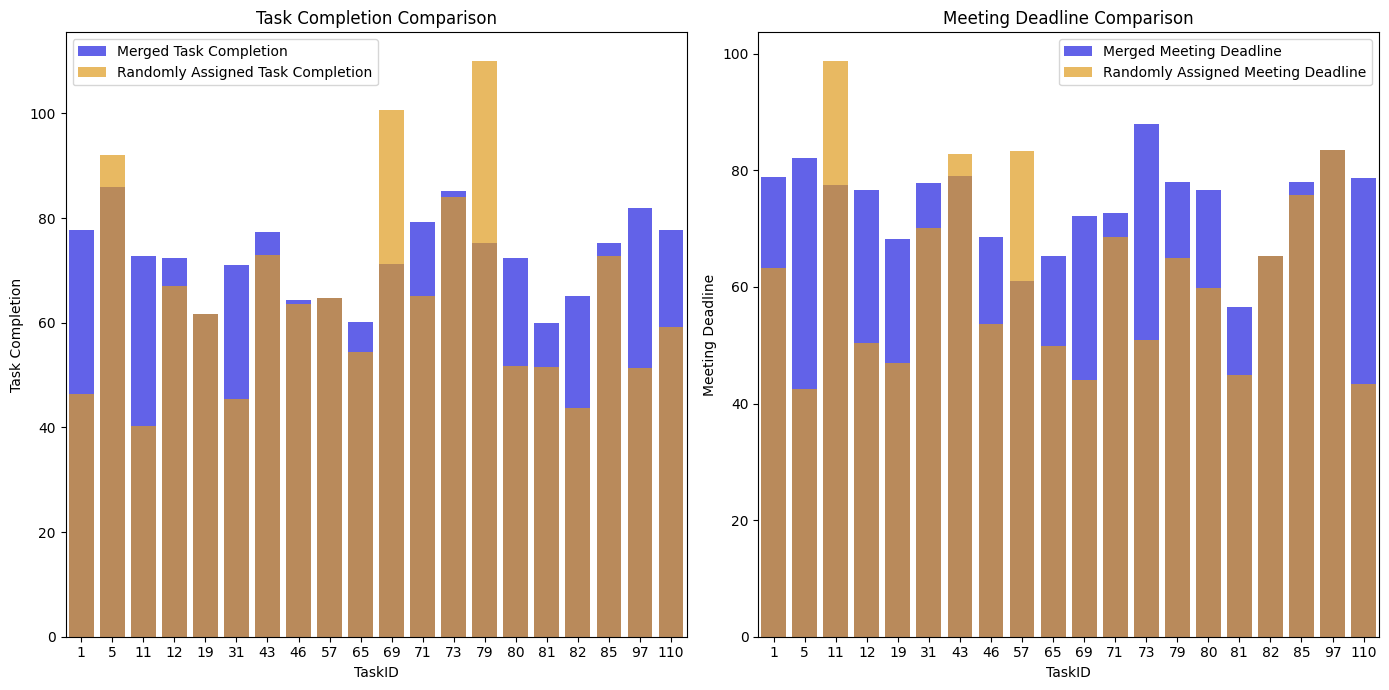

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Assuming merged_df and merged_random_assign_df are already defined ---

# Step 1: Randomly filter 3 to 4 tasks from each DataFrame
np.random.seed(42)  # For reproducibility

# Randomly select 4 task IDs
random_task_ids = np.random.choice(merged_df['TaskID'].unique(), size=20, replace=False)

# Filter both DataFrames based on these TaskIDs
merged_filtered = merged_df[merged_df['TaskID'].isin(random_task_ids)]
merged_random_filtered = merged_random_assign_df[merged_random_assign_df['TaskID'].isin(random_task_ids)]

# Step 2: Plot Task Completion and Meeting Deadline for the selected tasks
plt.figure(figsize=(14, 7))

# Task Completion Plot
plt.subplot(1, 2, 1)
sns.barplot(data=merged_filtered, x='TaskID', y='Task Completion', color='blue', label='Merged Task Completion', alpha=0.7)
sns.barplot(data=merged_random_filtered, x='TaskID', y='Task Completion', color='orange', label='Randomly Assigned Task Completion', alpha=0.7)
plt.title('Task Completion Comparison')
plt.xlabel('TaskID')
plt.ylabel('Task Completion')
plt.legend()

# Meeting Deadline Plot
plt.subplot(1, 2, 2)
sns.barplot(data=merged_filtered, x='TaskID', y='Meeting Deadline', color='blue', label='Merged Meeting Deadline', alpha=0.7)
sns.barplot(data=merged_random_filtered, x='TaskID', y='Meeting Deadline', color='orange', label='Randomly Assigned Meeting Deadline', alpha=0.7)
plt.title('Meeting Deadline Comparison')
plt.xlabel('TaskID')
plt.ylabel('Meeting Deadline')
plt.legend()

plt.tight_layout()
plt.show()



In [36]:
merged_random_assign_df.to_csv('merged_random_assign_df.csv', index=False)

In [37]:
merged_df.to_csv('merged_df.csv', index=False)